In [1]:
#Some packages needs to be installed in order to run this code
#Moving Pandas is the most complicated to install
#Get anaconda - create new environment


import numpy as np
import json

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data

#import requests
import geojson
from pyproj import CRS
#from owslib.wms import WebMapService
#from owslib.wcs import WebCoverageService

import scipy.stats as stats
from scipy.signal import lfilter

import random

#Packages for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Packages for interpreting elevation data
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

#MovingPandas (Kalman-filter)
import movingpandas as mpd

import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp

from datetime import datetime, timedelta
from holoviews import opts, dim

import time

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import pickle

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

# Welcome to part 2
We will
* make some decisions regarding what trips to exclude from the dataset
* generate the histogram for the optimization
* find some representative trips
* 

In [50]:
gm = pd.read_csv('gm_part1.csv')
gm.set_index(["og_idx","t"],inplace=True)
gm = gpd.GeoDataFrame(gm)
gm["geometry"] = gm['geometry'].apply(wkt.loads)
gm.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [51]:
gm.rename(columns={"trajectory_id":"id_origine"}, inplace=True)

In [52]:
gm.set_index(["id_origine"], inplace=True, append=True, drop=True)

In [53]:
gm = gm.reset_index(level='og_idx').copy()

In [54]:
gm.head(3)

og_idx  og_idx.1     length  purpose  \
t                          id_origine                                         
2013-06-25 16:21:45.473682 52               0         0  17.696519  Commute   
2013-06-25 16:21:46.833331 52               0         0   8.550044  Commute   
2013-06-25 16:21:48.192980 52               0         0  17.237975  Commute   

                                         duration                      dt  \
t                          id_origine                                       
2013-06-25 16:21:45.473682 52          527.543812  0 days 00:00:01.359649   
2013-06-25 16:21:46.833331 52          527.543812  0 days 00:00:01.359649   
2013-06-25 16:21:48.192980 52          527.543812  0 days 00:00:01.359649   

                                                         geometry  id  \
t                          id_origine                                   
2013-06-25 16:21:45.473682 52          POINT (-73.57786 45.50821)  18   
2013-06-25 16:21:46.833331 52          POINT (-73.57779 45.50828)  19   
2013-06-25 16:21:48.192980 52          POINT (-73.57773 45.50836)  20   

                                            vel  stop       acc      time  \
t                          id_origine                                       
2013-06-25 16:21:45.473682 52          7.552916     0 -0.070007  1.359649   
2013-06-25 16:21:46.833331 52          7.457731     0 -0.157558  1.359649   
2013-06-25 16:21:48.192980 52          7.243507     0 -0.244999  1.359649   

                                        timesum  
t                          id_origine            
2013-06-25 16:21:45.473682 52          0.000000  
2013-06-25 16:21:46.833331 52          1.359649  
2013-06-25 16:21:48.192980 52          2.719298

In [2]:
gm2 = pd.read_csv('gm_part1_b.csv')
gm2.set_index(["id_origine","t"],inplace=True)
gm2 = gpd.GeoDataFrame(gm2)
gm2["geometry"] = gm2['geometry'].apply(wkt.loads)
gm2.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [3]:
gm2.head(3)

trajectory_id  id  id_origine.1  \
id_origine t                                                             
52         2013-06-25 16:21:26.862510              0   4            52   
           2013-06-25 16:21:28.035012              0   5            52   
           2013-06-25 16:21:29.207514              0   6            52   

                                          length  purpose    duration  \
id_origine t                                                            
52         2013-06-25 16:21:26.862510  18.383815  Commute  470.173302   
           2013-06-25 16:21:28.035012  18.190607  Commute  470.173302   
           2013-06-25 16:21:29.207514   8.634287  Commute  470.173302   

                                                           dt  \
id_origine t                                                    
52         2013-06-25 16:21:26.862510  0 days 00:00:01.172502   
           2013-06-25 16:21:28.035012  0 days 00:00:01.172502   
           2013-06-25 16:21:29.207514  0 days 00:00:01.172502   

                                                         geometry        vel  \
id_origine t                                                                   
52         2013-06-25 16:21:26.862510  POINT (-73.57805 45.50725)  12.814298   
           2013-06-25 16:21:28.035012  POINT (-73.57818 45.50733)  12.302391   
           2013-06-25 16:21:29.207514  POINT (-73.57830 45.50741)  10.541754   

                                       stop       acc      time   timesum  
id_origine t                                                               
52         2013-06-25 16:21:26.862510     0 -0.436593  1.172502  0.000000  
           2013-06-25 16:21:28.035012     0 -1.501606  1.172502  1.172502  
           2013-06-25 16:21:29.207514     0 -1.869684  1.172502  2.345004

In [4]:
#gm["vel"].hist(bins=[x/10 for x in range(210)])

NameError: name 'gm' is not defined

<Axes: >

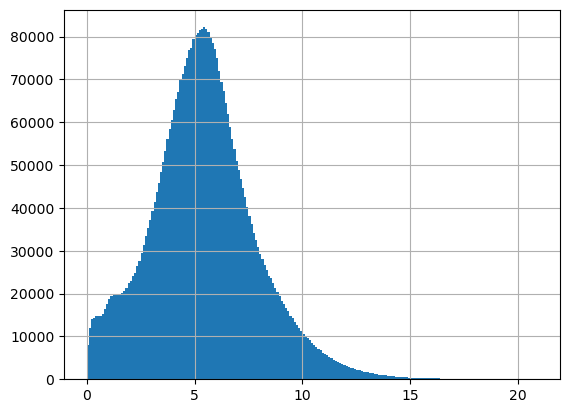

In [9]:
gm2["vel"].hist(bins=[x/10 for x in range(210)])

In [10]:
#gm_skew = gm.copy()
gm = gm2.copy()

In [11]:
gm

trajectory_id       id  id_origine.1  \
id_origine t                                                                  
52         2013-06-25 16:21:26.862510              0        4            52   
           2013-06-25 16:21:28.035012              0        5            52   
           2013-06-25 16:21:29.207514              0        6            52   
           2013-06-25 16:21:30.380016              0        7            52   
           2013-06-25 16:21:31.552518              0        8            52   
...                                              ...      ...           ...   
28938      2015-08-31 14:47:39.315108           9182  4297178         28938   
           2015-08-31 14:47:40.487610           9182  4297179         28938   
           2015-08-31 14:47:41.660112           9182  4297180         28938   
           2015-08-31 14:47:42.832614           9182  4297181         28938   
           2015-08-31 14:47:44.005116           9182  4297182         28938   

                                          length     purpose    duration  \
id_origine t                                                               
52         2013-06-25 16:21:26.862510  18.383815     Commute  470.173302   
           2013-06-25 16:21:28.035012  18.190607     Commute  470.173302   
           2013-06-25 16:21:29.207514   8.634287     Commute  470.173302   
           2013-06-25 16:21:30.380016   6.813815     Commute  470.173302   
           2013-06-25 16:21:31.552518   5.340468     Commute  470.173302   
...                                          ...         ...         ...   
28938      2015-08-31 14:47:39.315108   6.976099  Magasinage   59.797602   
           2015-08-31 14:47:40.487610   8.120286  Magasinage   59.797602   
           2015-08-31 14:47:41.660112   8.767340  Magasinage   59.797602   
           2015-08-31 14:47:42.832614   7.957226  Magasinage   59.797602   
           2015-08-31 14:47:44.005116   2.979232  Magasinage   59.797602   

                                                           dt  \
id_origine t                                                    
52         2013-06-25 16:21:26.862510  0 days 00:00:01.172502   
           2013-06-25 16:21:28.035012  0 days 00:00:01.172502   
           2013-06-25 16:21:29.207514  0 days 00:00:01.172502   
           2013-06-25 16:21:30.380016  0 days 00:00:01.172502   
           2013-06-25 16:21:31.552518  0 days 00:00:01.172502   
...                                                       ...   
28938      2015-08-31 14:47:39.315108  0 days 00:00:01.172502   
           2015-08-31 14:47:40.487610  0 days 00:00:01.172502   
           2015-08-31 14:47:41.660112  0 days 00:00:01.172502   
           2015-08-31 14:47:42.832614  0 days 00:00:01.172502   
           2015-08-31 14:47:44.005116  0 days 00:00:01.172502   

                                                         geometry        vel  \
id_origine t                                                                   
52         2013-06-25 16:21:26.862510  POINT (-73.57805 45.50725)  12.814298   
           2013-06-25 16:21:28.035012  POINT (-73.57818 45.50733)  12.302391   
           2013-06-25 16:21:29.207514  POINT (-73.57830 45.50741)  10.541754   
           2013-06-25 16:21:30.380016  POINT (-73.57838 45.50748)   8.349546   
           2013-06-25 16:21:31.552518  POINT (-73.57842 45.50754)   6.486741   
...                                                           ...        ...   
28938      2015-08-31 14:47:39.315108  POINT (-73.54475 45.54150)   5.692212   
           2015-08-31 14:47:40.487610  POINT (-73.54479 45.54144)   5.857093   
           2015-08-31 14:47:41.660112  POINT (-73.54482 45.54139)   5.890508   
           2015-08-31 14:47:42.832614  POINT (-73.54486 45.54133)   5.782137   
           2015-08-31 14:47:44.005116  POINT (-73.54489 45.54128)   5.647423   

                                       stop       acc      time    timesum  
id_origine t                                              

## Look at the data
remember that some of these trips have had "periods of bad readings" cut out, so don't be alarmed by "disjunct trips"

In [12]:
# longest trips in HOURS
gm.groupby(level=0)["duration"].mean().nlargest(5)/3600

id_origine
3756    5.084750
2812    4.843410
3203    4.540514
3757    3.959800
3082    3.514575
Name: duration, dtype: float64

In [13]:
# shortest trips in SECONDS
gm.groupby(level=0)["duration"].mean().nsmallest(5)

id_origine
14607     5.862510
23286     8.207514
848      12.897522
28175    16.415028
8593     17.587530
Name: duration, dtype: float64

In [14]:
# fastest mean velocities in km/h
gm.groupby(level=0)["vel"].mean().nlargest(3)*3.6

id_origine
972      63.902169
3601     51.341650
15991    45.844250
Name: vel, dtype: float64

In [15]:
# slowest mean velocities in km/h
gm.groupby(level=0)["vel"].mean().nsmallest(3)*3.6

id_origine
1525     2.029686
14227    2.808547
1128     2.837911
Name: vel, dtype: float64

## What to cut?

Suggestions:
* Trips shorter than 60 seconds
* Trips with mean velocity over x m/s (suggestion 11 m/s)
* Trips with mean velocity under x m/s ()
* Trips that never exceed x m/s
* Trips that exceed certain speeds for a majority of the time?

First we only cut the short and long trips

In [16]:
# We keep an original copy of the dataframe for comparison
# We could also look at "tc_save_part1.csv" to see the wholly unprocessed data
gm_nocut = gm.copy()

# you can also come back here and run
#gm = gm_nocut.copy()
# if you want to change some things

In [17]:
#keep only trips over 3 minutes and shorter than 2 hours
before_cutting = len(gm.groupby(level=0)["vel"].mean())
mintime = 3*60
maxtime = 2*3600
gm = gm.loc[(gm["duration"]>mintime) & (gm["duration"]<maxtime)].copy()
after_cutting = len(gm.groupby(level=0)["vel"].mean())

Again, we can look at the data. We see that cutting away the really short and long trips actually cut away our "worst offenders" re: mean velocity. 

In [18]:
print("we cut away ", before_cutting-after_cutting, " out of ", before_cutting, " trips")

we cut away  901  out of  4875  trips


In [19]:
#3 highest mean velocities [km/h]
gm.groupby(level=0)["vel"].mean().nlargest(3)*3.6

id_origine
972     63.902169
3601    51.341650
1752    43.327732
Name: vel, dtype: float64

In [20]:
#three lowest mean velocities [km/h]
gm.groupby(level=0)["vel"].mean().nsmallest(3)*3.6

id_origine
1525     2.029686
14227    2.808547
1128     2.837911
Name: vel, dtype: float64

In [21]:
# three lowest max velocities
N=3
gm.groupby(level=0)["vel"].max().nsmallest(N)

id_origine
14227    1.585887
11823    1.802477
3156     1.939479
Name: vel, dtype: float64

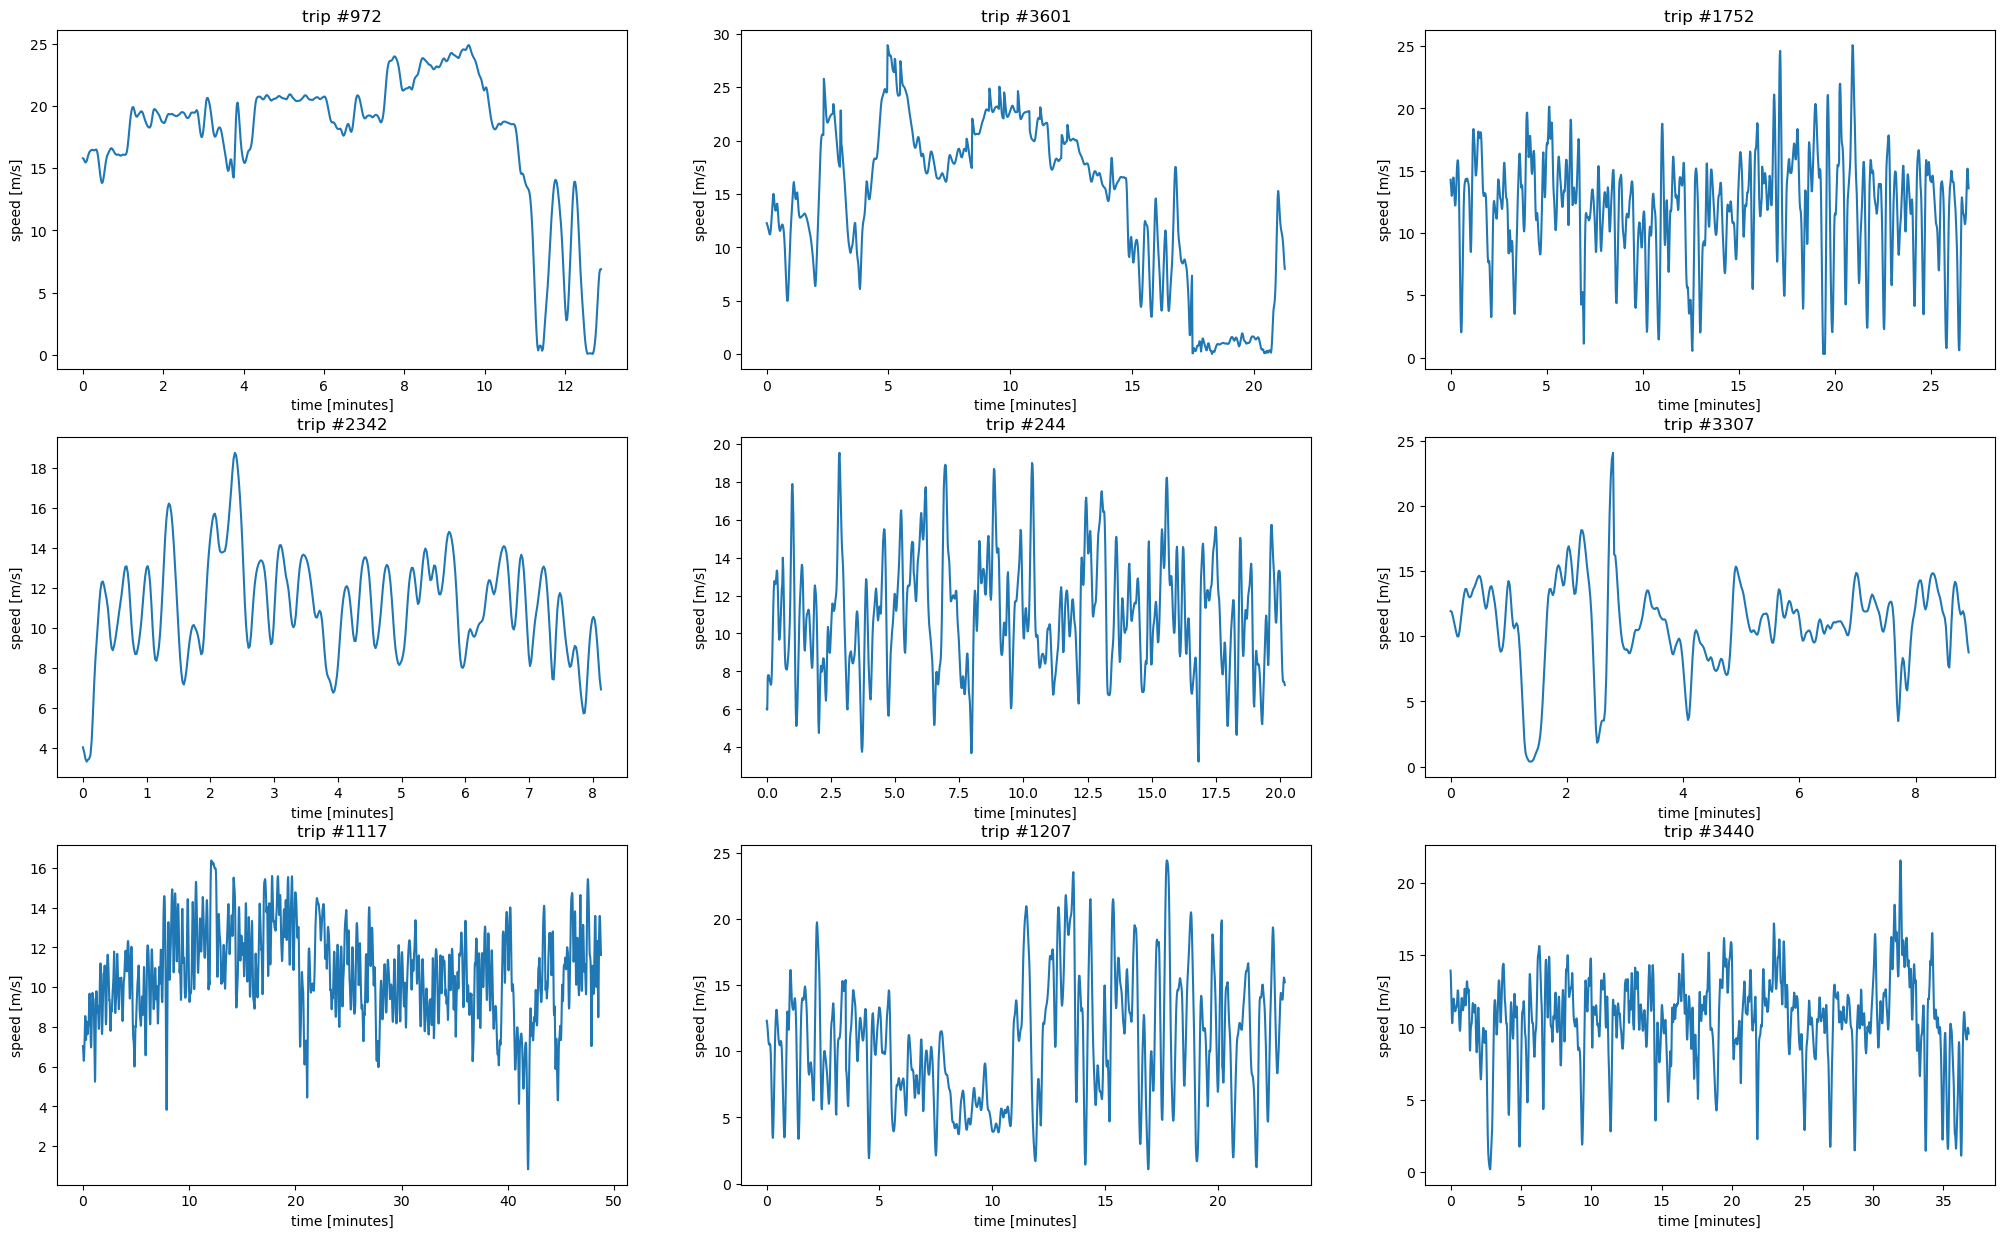

In [22]:
#paste any of the ones above to view the plot of the N trips

N = 9

trip_ids = gm.groupby(level=0)["vel"].mean().nlargest(N).index.tolist()
trips = [x for x in range(N)]


fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[i]#[trips[i]]
    times = [x/60 for x in gm.xs(trip)["timesum"].tolist()]
    vels = gm.xs(trip)["vel"].tolist()
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    #plt.xlim([0, 10])
    plt.title("trip #"+str(trip))

plt.show()

## Decisions
So here we might want to cut away more of the trips, but that's up to you

In [23]:
#to drop trips with mean velocities over a certain value, do the following
#val = 8.333
#trips = (gm.groupby(level=0)["vel"].mean() < val)[(gm.groupby(level=0)["vel"].mean() < val)].index.tolist()
#gm = gm.loc[trips].copy()

## Get the data for the optimization
Once we are satisfied with the data, we print the histogram to use in optimization

In [24]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm[grouped_variable_name] = pd.cut(
    gm[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [25]:
#print H
np.set_printoptions(suppress=True)
H = np.array(gm.groupby("vel_bin")["vel_bin"].count().tolist())
h = np.sum(H)/750
print("H =", np.round(H/h,2))

H = [ 1.39  2.01  2.4   2.5   2.58  2.61  2.58  2.64  2.84  3.02  3.17  3.28
  3.41  3.45  3.5   3.48  3.59  3.67  3.82  4.02  4.13  4.31  4.43  4.72
  4.94  5.25  5.62  5.96  6.3   6.64  6.99  7.4   7.74  8.13  8.59  8.97
  9.48  9.95 10.34 10.73 11.15 11.6  11.87 12.35 12.62 12.93 13.27 13.63
 13.71 14.03 14.2  14.24 14.36 14.35 14.44 14.36 14.25 13.92 13.72 13.45
 13.07 12.55 12.1  11.69 11.21 10.76 10.25  9.78  9.35  8.96  8.59  8.19
  7.89  7.51  7.1   6.76  6.46  6.11  5.81  5.53  5.22  5.06  4.78  4.6
  4.33  4.25  4.03  3.82  3.66  3.49  3.29  3.17  2.98  2.86  2.65  2.56
  2.4   2.27  2.15  2.01  1.91  1.82  1.74  1.63  1.53  1.44  1.35  1.26
  1.21  1.1   1.07  1.01  0.92  0.88  0.82  0.77  0.73  0.66  0.64  0.6
  0.58  0.53  0.48  0.46  0.41  0.39  0.38  0.36  0.32  0.31  0.29  0.27
  0.25  0.23  0.2   0.2   0.2   0.17  0.17  0.14  0.14  0.14  0.12  0.11
  0.11  0.1   0.1   0.09  0.09  0.08  0.07  0.07  0.07  0.06  0.06  0.05
  0.05  0.05  0.04  0.04  0.04  0.04  0.04  0.04 

## Representative trips/segments
The idea is to compare segements to the whole data-set. 

Things to compare:
* Mean acceleration
* Mean velocity
* Idling time/minute
* Idling time specifically around mean velocity/minute
* number of stops/minute
* time spent "stopping"/minute


This can either be done by comparing whole trips to the dataset or MiniTrips. \
With MTs we can either cut up a trip
* at natural stopping points or
* every x minutes

## Cut the trips into MiniTrips MTs
based on natural stopping points. 
* It's been a while since I wrote this
* This is really a decision that needs to be made how/if we want to cut up the trips into smaller segments before analyzing them
* Arguments could be made...
* The comparison/analysis works regardless
* Right now I have skipped running this section
### Method
We now find all breakpoints, as well as add the first elem in each OG trip as a breakpoint.
\
We also do not want any breakpoint when there is less than 3 minutes left, so we make sure this is the case

In [107]:
mintime=180

gm["MT"] = 0
gm.loc[gm["stop"]==2, "MT"] = 1 #add breakpoint (stop)

gm["rev_ts"] = gm.loc[::-1,"time"].groupby(level=0).cumsum()[::-1] #reverse timesum
gm.loc[gm["rev_ts"] < mintime, "MT"] = 0 #reset any breakpoint, closer than mintime seconds from the end, to zero
gm.loc[gm["timesum"]< mintime, "MT"] = 0 #reset any breakpoint, closer than mintime seconds from the start, to zero

gm.loc[gm.groupby(level=0).head(1).index, "MT"] = 1 #add breakpoint beginning of OG trip

Now we drop all breakpoints that create MTs shorter than 3 minutes. It is an iterative process, and takes a little while

In [108]:
#find the time-diff between stops
#all other will be set to mintime
gm["tf"] = mintime
gm.loc[gm["MT"]==1, "tf"] = ((-gm.loc[gm["MT"]==1].groupby(level=0, group_keys=False)["timesum"].apply(lambda x: x.diff(periods=-1))).tolist())
gm["tf"].fillna(mintime, inplace=True)

gm.loc[gm.loc[(gm["MT"]>=1) & (gm["tf"]<mintime)].groupby(level=0).tail(1).index, "MT"] = 0

KeyboardInterrupt: 

In [ ]:
#WRITE BETTER CODE FOR THIS!!!

a = len(gm.loc[(gm["MT"]>=1) & (gm["tf"]<mintime)].groupby(level=0).tail(1))

while a > 0:
    gm["tf"] = mintime
    gm.loc[gm["MT"]==1, "tf"] = ((-gm.loc[gm["MT"]==1].groupby(level=0, group_keys=False)["timesum"].apply(lambda x: x.diff(periods=-1))).tolist())
    gm["tf"].fillna(mintime, inplace=True)
    gm.loc[gm.loc[(gm["MT"]>=1) & (gm["tf"]<mintime)].groupby(level=0).tail(1).index, "MT"] = 0
    a = len(gm.loc[(gm["MT"]>=1) & (gm["tf"]<mintime)].groupby(level=0).tail(1))
    print(a)
    
gm["tf"] = mintime
gm.loc[gm["MT"]==1, "tf"] = ((-gm.loc[gm["MT"]==1].groupby(level=0, group_keys=False)["timesum"].apply(lambda x: x.diff(periods=-1))).tolist())
gm["tf"].fillna(mintime, inplace=True)

In [ ]:
gm_MT_savepoint = gm.copy()

#gm = gm_MT_savepoint.copy()

In [ ]:
gm.drop(columns=["rev_ts", "tf"], inplace=True)

## index MiniTrips

we can now index based on MiniTrips
and reset the duration and timesum accordingly

In [552]:
gm["MT"] = gm["MT"].cumsum()

In [553]:
gm.set_index(["MT"], inplace=True,
             append=True, drop=False)

gm.reset_index(level=0,inplace=True)

gm = gm.reorder_levels(["MT", "t"]).copy()

In [554]:
gm["timesum"] = gm.groupby(level=0)["time"].cumsum()

In [555]:
gm["duration"] = np.nan
#set last elem in group to its timesum-value = the duration of this MT
gm.loc[gm.groupby(level=0).tail(1).index, "duration"] = gm.groupby(level=0).tail(1)["timesum"].tolist()
gm["duration"].fillna(method="bfill",inplace=True)

## look at the cut trips

In [587]:
#we still have some pretty long trips in there (MINUTES)
gm.groupby(level=0)["duration"].mean().nlargest(200)/60

MT
3325    56.631847
1710    54.658135
412     54.540885
1178    53.075257
3763    52.606256
          ...    
3340    29.879259
2372    29.859718
4879    29.820634
2928    29.781551
4237    29.644759
Name: duration, Length: 200, dtype: float64

In [114]:
#we still have some pretty long trips in there (MINUTES)
gm.groupby(level=0)["duration"].mean().nlargest(200)/60

id_origine
2812    290.604621
3203    272.430840
3082    210.874485
1911    189.495865
2301    177.673136
           ...    
1842     47.271372
3969     47.232289
3282     47.193205
565      47.154122
701      46.919622
Name: duration, Length: 200, dtype: float64

In [569]:
# METERS PER SECOND
gm.loc[gm.groupby(level=0)["duration"].mean().nlargest(10).index].groupby(level=0)["vel"].mean()

MT
412      7.206203
1167    10.616294
1178     7.193341
1710     5.431494
2150     4.856744
3325     7.104738
3763     5.054585
6075     6.761437
6295     7.243573
7086     9.446382
Name: vel, dtype: float64

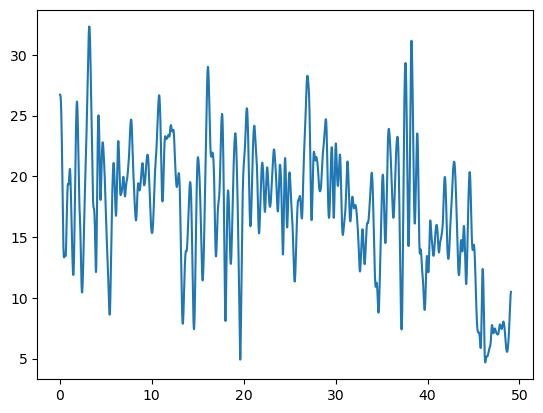

In [571]:
i = 2150
plt.plot(gm.loc[i]["timesum"]/60, gm.loc[i]["vel"]*3.6)

## Notes
* We see that this method of cutting the trips still result in som really long MTs
* the average (time) length of an MT is 10 minutes - but this includes some really long trips.
* The median (time) length of an MT is 7 minutes
* BUT we have already cut away/concetated everything shorter than 3 minutes which might have skewed the data upwards.
* I did go back and ran this without cutting/concetating < 3 min segments and then the mean segment is 5.2 minutes and the median is 2.2 minutes long.

(The "first mean" in the code is just to get one number representing the whole group, it could be substituted with max(), min(), etc.. )
(divide by 60 to get it in minutes)

In [115]:
# median in MINUTES
gm.groupby(level=0)["duration"].mean().median()/60

16.2000693

In [116]:
# mean in MINUTES
gm.groupby(level=0)["duration"].max().mean()/60

21.269219499445676

In [117]:
# this is the number of MTs that are over 10 minutes, but in this case it is actually 2300, 
# I just accidentally ran this part of the code with a different gm
len(gm.loc[gm["duration"]>10*60].groupby(level=0))

1923

In [118]:
# Total number of MTs
len(gm.groupby(level=0))

2706

## Comparison 
Regardless of whether we cut up the trips or not, we can compare our trips/MTs to the whole dataset \
\
\
We create a dataframe which we will fill with the characteristic parameters for each trip
* mean velocity
* mean acceleration
* mean deceleration
* percentage of idling time
* time spent accelerating
* time spend cruising
* max velocity
* max acceleration
* min (max) deceleration

There are of course other parameters that could be considered characteristic, such as "duration", "reason for trip", etc.

Also note that mean vel/acc/dec is calculated based on *number of occurences*, while operational modes are calculated based on *time spent in that mode*. Make a decision here as to how to handle this! (Maybe find a geometry with even dt)

(OG timestep as a param? No, but also maybe to see.. )

In [26]:
#create dataframe to keep track of unique values for all trips
gm_idx = pd.DataFrame(index=gm.index.unique(level=0).tolist())

In [27]:
#add mean vel, mean acc, mean dec to each MT
gm_idx["vel_mean"] = gm.groupby(level=0)["vel"].mean()

gm["pos_acc"] = gm["acc"]
gm.loc[gm["pos_acc"] < 0 , "pos_acc"] = np.nan
gm_idx["acc_mean"] = gm.groupby(level=0)["pos_acc"].mean()


gm["neg_acc"] = gm["acc"]
gm.loc[gm["neg_acc"] > 0 , "neg_acc"] = np.nan
gm_idx["dec_mean"] = gm.groupby(level=0)["neg_acc"].mean()

## How to define idling time?
There are two ways
* based on if point is part of "stop" as assigned by smoother (see part1 for specific parameters)?
* based on if vel is < 2m/s (or other velocity)

Doing some comparison below

* The mean ratio between the two is 1 : 1.31  (or 1:1.22 in the case of using not cut up trips)
* The ones that are really high on "vel<2" compared to low on "stop-assign" seem to be trips that contain longer segments where the vel is around 2m/s

We add them up for now (i.e., we consider both instances to be idling) \
(of course, no point is counted twice)

In [28]:
(gm.loc[gm["vel"]<2].groupby(level=0)["id"].count() / gm.loc[gm["stop"]>0].groupby(level=0)["id"].count()).fillna(0).mean()

0.9521256199366369

In [29]:
(gm.loc[gm["vel"]<2].groupby(level=0)["id"].count() / gm.loc[gm["stop"]>0].groupby(level=0)["id"].count()).nlargest(5)

id_origine
3438    17.200000
2987    13.128205
2200    12.900000
653     11.095238
3241    10.317073
Name: id, dtype: float64

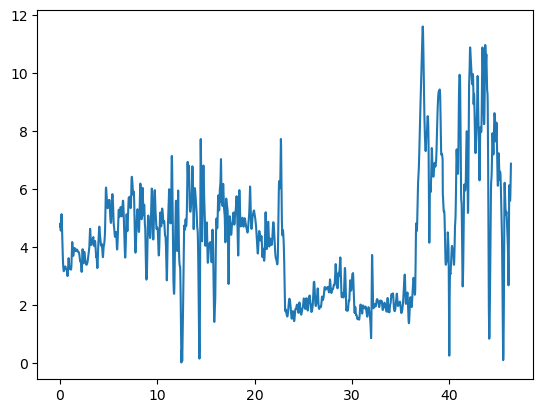

In [30]:
i = 3438
plt.plot(gm.loc[i]["timesum"]/60, gm.loc[i]["vel"])

In [31]:
(gm.loc[gm["vel"]<2].groupby(level=0)["id"].count() / gm.loc[gm["stop"]>0].groupby(level=0)["id"].count()).nsmallest(4)

id_origine
2127     0.031746
17215    0.157895
24074    0.250000
24619    0.250000
Name: id, dtype: float64

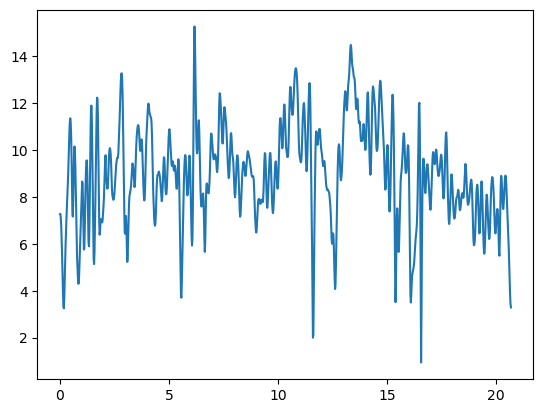

In [32]:
i = 2127
plt.plot(gm.loc[i]["timesum"]/60, gm.loc[i]["vel"])

In [33]:
gm["idle"] = 0
gm.loc[gm["vel"]<2, "idle"] = 1
gm.loc[gm["stop"]>0, "idle"] = 1

In [34]:
#add percentage of time spent idling
gm_idx["idle"] = gm.groupby(level=0)["idle"].sum()/gm.groupby(level=0)["id"].count()


#(gm["stop"]*gm["time"]).groupby(level=0).sum()/gm.groupby(level=0)["duration"].mean()

In [35]:
#time spent cruising
cruise_lim = 0.1 #[m/s^2]

gm["cruise"] = 1
gm.loc[gm["acc"] < -cruise_lim , "cruise"] = 0
gm.loc[gm["acc"] > cruise_lim , "cruise"] = 0

gm_idx["cruise"] = gm.groupby(level=0)["cruise"].sum()/gm.groupby(level=0)["id"].count()

#gm_idx["cruise"] = ((gm["cruise"]*gm["time"]).groupby(level=0).sum())/(gm.groupby(level=0)["duration"].mean())

#gm_idx["cruise"] = (gm.groupby(level=0)["cruise"].apply(lambda x: x.sum())/gm.groupby(level=0)["vel"].apply(lambda x: x.count())).tolist()

In [36]:
#time spent accelerating
cruise_lim = 0.1 #[m/s^2]

gm["acc_time"] = 1
gm.loc[gm["acc"] < cruise_lim , "acc_time"] = 0

gm_idx["acc_time"] = gm.groupby(level=0)["acc_time"].sum()/gm.groupby(level=0)["id"].count()

#gm_idx["acc_time"] = (gm["acc_time"]*gm["time"]).groupby(level=0).sum()/gm.groupby(level=0)["duration"].mean()

#gm_idx["acc_time"] = (gm.groupby(level=0)["acc_time"].apply(lambda x: x.sum())/gm.groupby(level=0)["vel"].apply(lambda x: x.count())).tolist()

In [37]:
gm_idx["vel_max"] = gm.groupby(level=0)["vel"].max()
gm_idx["acc_max"] = gm.groupby(level=0)["acc"].max()
gm_idx["dec_min"] = gm.groupby(level=0)["acc"].min()

In [38]:
#if no accel/decel takes place during a trip, this would be set to NaN, so here we just set those to zero
gm_idx["acc_mean"].fillna(0, inplace=True)
gm_idx["dec_mean"].fillna(0, inplace=True)

In [39]:
#gm_idx["duration"] = gm.groupby(level=0).head(1)["duration"].tolist()
gm

trajectory_id       id  id_origine.1  \
id_origine t                                                                  
52         2013-06-25 16:21:26.862510              0        4            52   
           2013-06-25 16:21:28.035012              0        5            52   
           2013-06-25 16:21:29.207514              0        6            52   
           2013-06-25 16:21:30.380016              0        7            52   
           2013-06-25 16:21:31.552518              0        8            52   
...                                              ...      ...           ...   
28904      2015-08-30 19:42:10.720704           9180  4297121         28904   
           2015-08-30 19:42:11.893206           9180  4297122         28904   
           2015-08-30 19:42:13.065708           9180  4297123         28904   
           2015-08-30 19:42:14.238210           9180  4297124         28904   
           2015-08-30 19:42:15.410712           9180  4297125         28904   

                                          length     purpose    duration  \
id_origine t                                                               
52         2013-06-25 16:21:26.862510  18.383815     Commute  470.173302   
           2013-06-25 16:21:28.035012  18.190607     Commute  470.173302   
           2013-06-25 16:21:29.207514   8.634287     Commute  470.173302   
           2013-06-25 16:21:30.380016   6.813815     Commute  470.173302   
           2013-06-25 16:21:31.552518   5.340468     Commute  470.173302   
...                                          ...         ...         ...   
28904      2015-08-30 19:42:10.720704   7.733600  Magasinage  406.858194   
           2015-08-30 19:42:11.893206   8.239877  Magasinage  406.858194   
           2015-08-30 19:42:13.065708   3.842770  Magasinage  406.858194   
           2015-08-30 19:42:14.238210   7.992363  Magasinage  406.858194   
           2015-08-30 19:42:15.410712   6.152249  Magasinage  406.858194   

                                                           dt  \
id_origine t                                                    
52         2013-06-25 16:21:26.862510  0 days 00:00:01.172502   
           2013-06-25 16:21:28.035012  0 days 00:00:01.172502   
           2013-06-25 16:21:29.207514  0 days 00:00:01.172502   
           2013-06-25 16:21:30.380016  0 days 00:00:01.172502   
           2013-06-25 16:21:31.552518  0 days 00:00:01.172502   
...                                                       ...   
28904      2015-08-30 19:42:10.720704  0 days 00:00:01.172502   
           2015-08-30 19:42:11.893206  0 days 00:00:01.172502   
           2015-08-30 19:42:13.065708  0 days 00:00:01.172502   
           2015-08-30 19:42:14.238210  0 days 00:00:01.172502   
           2015-08-30 19:42:15.410712  0 days 00:00:01.172502   

                                                         geometry        vel  \
id_origine t                                                                   
52         2013-06-25 16:21:26.862510  POINT (-73.57805 45.50725)  12.814298   
           2013-06-25 16:21:28.035012  POINT (-73.57818 45.50733)  12.302391   
           2013-06-25 16:21:29.207514  POINT (-73.57830 45.50741)  10.541754   
           2013-06-25 16:21:30.380016  POINT (-73.57838 45.50748)   8.349546   
           2013-06-25 16:21:31.552518  POINT (-73.57842 45.50754)   6.486741   
...                                                           ...        ...   
28904      2015-08-30 19:42:10.720704  POINT (-73.57326 45.52102)   5.152124   
           2015-08-30 19:42:11.893206  POINT (-73.57319 45.52099)   5.329497   
           2015-08-30 19:42:13.065708  POINT (-73.57312 45.52096)   5.410399   
           2015-08-30 19:42:14.238210  POINT (-73.57306 45.52092)   5.473211   
           2015-08-30 19:42:15.410712  POINT (-73.57299 45.52089)   5.495610   

                                       stop       acc      time     timesum  \
id_origine t                                            

In [40]:
gm.loc[(gm["idle"]!=0) & (gm["stop"]==0)]

#gm.loc[gm["stop"]==1].groupby(level=0)["stop"].sum()#/
#(gm.groupby(level=0)["time"].sum())

trajectory_id       id  id_origine.1  \
id_origine t                                                                  
52         2013-06-25 16:25:02.602878              0      188            52   
           2013-06-25 16:25:03.775380              0      189            52   
           2013-06-25 16:25:04.947882              0      190            52   
           2013-06-25 16:25:06.120384              0      191            52   
           2013-06-25 16:25:07.292886              0      192            52   
...                                              ...      ...           ...   
28904      2015-08-30 19:38:58.430376           9180  4296957         28904   
           2015-08-30 19:38:59.602878           9180  4296958         28904   
           2015-08-30 19:39:00.775380           9180  4296959         28904   
           2015-08-30 19:39:01.947882           9180  4296960         28904   
           2015-08-30 19:40:02.917986           9180  4297012         28904   

                                         length     purpose    duration  \
id_origine t                                                              
52         2013-06-25 16:25:02.602878  0.933309     Commute  470.173302   
           2013-06-25 16:25:03.775380  0.676850     Commute  470.173302   
           2013-06-25 16:25:04.947882  0.585924     Commute  470.173302   
           2013-06-25 16:25:06.120384  1.224356     Commute  470.173302   
           2013-06-25 16:25:07.292886  0.327905     Commute  470.173302   
...                                         ...         ...         ...   
28904      2015-08-30 19:38:58.430376  1.836372  Magasinage  406.858194   
           2015-08-30 19:38:59.602878  1.063612  Magasinage  406.858194   
           2015-08-30 19:39:00.775380  2.988540  Magasinage  406.858194   
           2015-08-30 19:39:01.947882  3.173762  Magasinage  406.858194   
           2015-08-30 19:40:02.917986  1.820452  Magasinage  406.858194   

                                                           dt  \
id_origine t                                                    
52         2013-06-25 16:25:02.602878  0 days 00:00:01.172502   
           2013-06-25 16:25:03.775380  0 days 00:00:01.172502   
           2013-06-25 16:25:04.947882  0 days 00:00:01.172502   
           2013-06-25 16:25:06.120384  0 days 00:00:01.172502   
           2013-06-25 16:25:07.292886  0 days 00:00:01.172502   
...                                                       ...   
28904      2015-08-30 19:38:58.430376  0 days 00:00:01.172502   
           2015-08-30 19:38:59.602878  0 days 00:00:01.172502   
           2015-08-30 19:39:00.775380  0 days 00:00:01.172502   
           2015-08-30 19:39:01.947882  0 days 00:00:01.172502   
           2015-08-30 19:40:02.917986  0 days 00:00:01.172502   

                                                         geometry       vel  \
id_origine t                                                                  
52         2013-06-25 16:25:02.602878  POINT (-73.57592 45.51025)  0.522940   
           2013-06-25 16:25:03.775380  POINT (-73.57592 45.51026)  0.539094   
           2013-06-25 16:25:04.947882  POINT (-73.57592 45.51026)  0.516773   
           2013-06-25 16:25:06.120384  POINT (-73.57592 45.51027)  0.446931   
           2013-06-25 16:25:07.292886  POINT (-73.57591 45.51027)  0.330425   
...                                                           ...       ...   
28904      2015-08-30 19:38:58.430376  POINT (-73.57410 45.52255)  1.914523   
           2015-08-30 19:38:59.602878  POINT (-73.57412 45.52254)  1.808472   
           2015-08-30 19:39:00.775380  POINT (-73.57414 45.52252)  1.834510   
           2015-08-30 19:39:01.947882  POINT (-73.57416 45.52251)  1.945114   
           2015-08-30 19:40:02.917986  POINT (-73.57496 45.52157)  1.879873   

                                       stop       acc      time     timesum  \
id_origine t                                                                  
52 

### gm_idx
so for each trip we have 
* mean velocity [m/s]
* mean acceleration [m/s^2] (when accelerating, at what rate do we accelerate)
* mean deceleration [m/s^2] (---/---)
* idling time [%]
* cruising time [%]
* acceleration time [%]
* We do not include deceleration time since that is just: 1 - acc_time-cruise-idle
* maximum velocity
* maximum acceleration
* minimum (or maximum in magnitude) deceleration

In [41]:
gm_idx.head()

vel_mean  acc_mean  dec_mean      idle    cruise  acc_time    vel_max  \
52    6.168561  0.496441 -0.476042  0.492537  0.296020  0.350746  22.961251   
2326  5.198531  0.272750 -0.303221  0.059032  0.226682  0.391972  14.421558   
53    7.080302  0.275082 -0.375496  0.020710  0.207101  0.431953  14.468527   
56    6.289012  0.235636 -0.226721  0.018625  0.395415  0.285100  12.672264   
133   7.865232  0.391457 -0.387066  0.028244  0.183583  0.403354  16.465983   

       acc_max   dec_min  
52    2.749240 -3.239572  
2326  1.161529 -1.093187  
53    0.896194 -1.567430  
56    2.397607 -1.068945  
133   2.089436 -1.718679

# STOPS
How often do we stop?
* From the smoother we found all stops based on if the cyclist did not move outside of a diameter of 30 meters in 20 seconds (these are marked with 2 in the "stop" column)
* We could also consider each time they go below 2m/s and then up again as a stop point
* Let's compare the results!

In [69]:
gf = gm.copy()

In [74]:
stops1 = gf.loc[gf["stop"]==2]["stop"].count()
print("based on not moving outide of a diameter, etc.. we have ", stops1, " number of stops")
gf["tf"] = 0
gf.loc[gf["vel"] <2, "tf"] = 1
gf["tf"] = gf["tf"] - gf["tf"].shift(fill_value=0)
gf["tf"] = np.abs(gf["tf"])
stops2 = gf["tf"].sum()/2
print("based on time dropping below 2m/s we have ", int(stops2), " number of stops")

based on not moving outide of a diameter, etc.. we have  8188  number of stops
based on time dropping below 2m/s we have  28643  number of stops


In [167]:
timestep = 1.172502 # [s]
total_time = len(gf["tf"])*timestep/60 # [min] total time in minutes
total_time2 = len(gf.loc[gf["check_stop"] != 0])/60

stops1_per25 = 25*stops1/total_time2
stops2_per25 = 25*stops2/total_time
print("based on not moving outide of a diameter, etc.. we stop ", stops1_per25, " times in 25 minutes")
print("based on time dropping below 2m/s we  we stop ", stops2_per25, " times in 25 minutes")



based on not moving outide of a diameter, etc.. we stop  5.81931689122824  times in 25 minutes
based on time dropping below 2m/s we  we stop  9.485669231469739  times in 25 minutes


In [101]:
gf["tf0"] = 0
gf.loc[gf["stop"]==2, "tf0"] = 1


In [143]:
(60*25*gf.loc[gf["tf0"] !=0].groupby(level=0)["tf0"].sum()/(gf.groupby(level=0)["id"].count()*1.172502)).mean()

5.580371012771939

In [94]:
(60*25*gf.groupby(level=0)["tf0"].sum()/(gf.groupby(level=0)["id"].count()*1.172502)).mean()

2.9025231211372917

In [95]:
(60*25*gf.groupby(level=0)["tf"].sum()/(gf.groupby(level=0)["id"].count()*1.172502*2)).mean()

10.79438411638531

In [124]:
total_trips = len(gf.groupby(level=0).head(1))
print(total_trips)

3974


In [125]:
trips_no_stops1 = len(gf.loc[gf["tf0"] !=0].groupby(level=0).head(1))
print(trips_no_stops1)

2067


In [126]:
trips_no_stops2 = len(gf.loc[gf["tf"] !=0].groupby(level=0).head(1))
print(trips_no_stops2)

3681


In [ ]:
#trips_no_stops2 = len(gf.loc[(gf["tf"] !=0) & (gf["tf0"] != 0)].groupby(level=0).head(1))
#print(trips_no_stops2)

In [152]:
gf["check_stop"] = np.nan
gf.loc[gf.groupby(level=0).head(1).index, "check_stop"] = gf.groupby(level=0)["tf0"].sum().tolist()
gf["check_stop"].ffill(inplace=True)

In [165]:
gf.loc[gf["check_stop"] != 0]

trajectory_id       id  id_origine.1  \
id_origine t                                                                  
52         2013-06-25 16:21:26.862510              0        4            52   
           2013-06-25 16:21:28.035012              0        5            52   
           2013-06-25 16:21:29.207514              0        6            52   
           2013-06-25 16:21:30.380016              0        7            52   
           2013-06-25 16:21:31.552518              0        8            52   
...                                              ...      ...           ...   
28904      2015-08-30 19:42:10.720704           9180  4297121         28904   
           2015-08-30 19:42:11.893206           9180  4297122         28904   
           2015-08-30 19:42:13.065708           9180  4297123         28904   
           2015-08-30 19:42:14.238210           9180  4297124         28904   
           2015-08-30 19:42:15.410712           9180  4297125         28904   

                                          length     purpose    duration  \
id_origine t                                                               
52         2013-06-25 16:21:26.862510  18.383815     Commute  470.173302   
           2013-06-25 16:21:28.035012  18.190607     Commute  470.173302   
           2013-06-25 16:21:29.207514   8.634287     Commute  470.173302   
           2013-06-25 16:21:30.380016   6.813815     Commute  470.173302   
           2013-06-25 16:21:31.552518   5.340468     Commute  470.173302   
...                                          ...         ...         ...   
28904      2015-08-30 19:42:10.720704   7.733600  Magasinage  406.858194   
           2015-08-30 19:42:11.893206   8.239877  Magasinage  406.858194   
           2015-08-30 19:42:13.065708   3.842770  Magasinage  406.858194   
           2015-08-30 19:42:14.238210   7.992363  Magasinage  406.858194   
           2015-08-30 19:42:15.410712   6.152249  Magasinage  406.858194   

                                                           dt  \
id_origine t                                                    
52         2013-06-25 16:21:26.862510  0 days 00:00:01.172502   
           2013-06-25 16:21:28.035012  0 days 00:00:01.172502   
           2013-06-25 16:21:29.207514  0 days 00:00:01.172502   
           2013-06-25 16:21:30.380016  0 days 00:00:01.172502   
           2013-06-25 16:21:31.552518  0 days 00:00:01.172502   
...                                                       ...   
28904      2015-08-30 19:42:10.720704  0 days 00:00:01.172502   
           2015-08-30 19:42:11.893206  0 days 00:00:01.172502   
           2015-08-30 19:42:13.065708  0 days 00:00:01.172502   
           2015-08-30 19:42:14.238210  0 days 00:00:01.172502   
           2015-08-30 19:42:15.410712  0 days 00:00:01.172502   

                                                         geometry        vel  \
id_origine t                                                                   
52         2013-06-25 16:21:26.862510  POINT (-73.57805 45.50725)  12.814298   
           2013-06-25 16:21:28.035012  POINT (-73.57818 45.50733)  12.302391   
           2013-06-25 16:21:29.207514  POINT (-73.57830 45.50741)  10.541754   
           2013-06-25 16:21:30.380016  POINT (-73.57838 45.50748)   8.349546   
           2013-06-25 16:21:31.552518  POINT (-73.57842 45.50754)   6.486741   
...                                                           ...        ...   
28904      2015-08-30 19:42:10.720704  POINT (-73.57326 45.52102)   5.152124   
           2015-08-30 19:42:11.893206  POINT (-73.57319 45.52099)   5.329497   
           2015-08-30 19:42:13.065708  POINT (-73.57312 45.52096)   5.410399   
           2015-08-30 19:42:14.238210  POINT (-73.57306 45.52092)   5.473211   
           2015-08-30 19:42:15.410712  POINT (-73.57299 45.52089)   5.495610   

                                       stop  ...     timesum  vel_bin  \
id_origine t                                 ...              

In [162]:
gf.groupby(level=0).head(1)["check_stop"]

id_origine  t                         
52          2013-06-25 16:21:26.862510    6.0
2326        2013-07-25 14:19:25.552518    0.0
53          2013-06-25 16:21:28.207514    0.0
56          2013-06-26 12:46:11.552518    0.0
133         2013-07-02 12:05:58.552518    0.0
                                         ... 
28885       2015-08-30 13:05:36.207514    2.0
28853       2015-07-04 17:10:55.552518    0.0
28859       2015-08-29 17:28:21.552518    0.0
28893       2015-08-30 15:40:38.207514    2.0
28904       2015-08-30 19:35:28.552518    6.0
Name: check_stop, Length: 3974, dtype: float64

In [181]:
len(gf.loc[gf["check_stop"] == 0]["vel"])

1752474

1752474


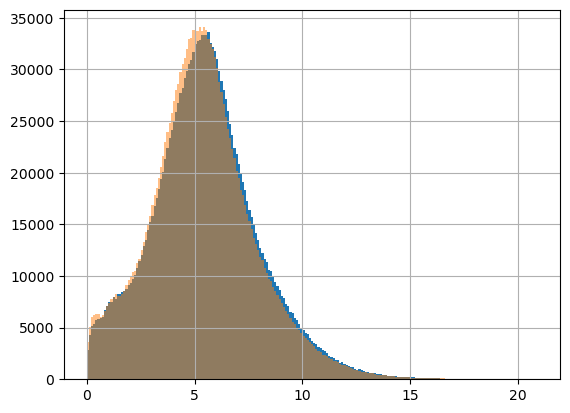

In [183]:
n = min([len(gf.loc[gf["check_stop"] > 0]["vel"]), len(gf.loc[gf["check_stop"] == 0]["vel"])])
print(n)
#gm_skew["vel"].hist(bins=[x/10 for x in range(210)])
gf.loc[gf["check_stop"]==0].sample(n)["vel"].hist(bins=[x/10 for x in range(210)])
#tc_save["vel"].hist(bins=[x/10 for x in range(210)], alpha=0.5)
gf.loc[gf["check_stop"] > 0].sample(n)["vel"].hist(bins=[x/10 for x in range(210)], alpha=0.5)
#plt.xlim([0,10])
plt.show()

In [119]:
gf.loc[gf["check_stop"] !=0].groupby(level=0).head(1)

trajectory_id       id  id_origine.1  \
id_origine t                                                                  
52         2013-06-25 16:21:26.862510              0        4            52   
2326       2013-07-25 14:19:25.552518              2      489          2326   
53         2013-06-25 16:21:28.207514              3     1342            53   
56         2013-06-26 12:46:11.552518              5     1696            56   
133        2013-07-02 12:05:58.552518              8     2515           133   
...                                              ...      ...           ...   
28885      2015-08-30 13:05:36.207514           9173  4295778         28885   
28853      2015-07-04 17:10:55.552518           9174  4295950         28853   
28859      2015-08-29 17:28:21.552518           9175  4296209         28859   
28893      2015-08-30 15:40:38.207514           9177  4296379         28893   
28904      2015-08-30 19:35:28.552518           9180  4296778         28904   

                                          length           purpose  \
id_origine t                                                         
52         2013-06-25 16:21:26.862510  18.383815           Commute   
2326       2013-07-25 14:19:25.552518  10.261117           Courses   
53         2013-06-25 16:21:28.207514   9.555757           Commute   
56         2013-06-26 12:46:11.552518   5.878582  Domicile-travail   
133        2013-07-02 12:05:58.552518   6.553690            School   
...                                          ...               ...   
28885      2015-08-30 13:05:36.207514   5.666526        Magasinage   
28853      2015-07-04 17:10:55.552518   5.201153             other   
28859      2015-08-29 17:28:21.552518   3.040028           Travail   
28893      2015-08-30 15:40:38.207514   6.121290        Magasinage   
28904      2015-08-30 19:35:28.552518   2.606328        Magasinage   

                                          duration                      dt  \
id_origine t                                                                 
52         2013-06-25 16:21:26.862510   470.173302  0 days 00:00:01.172502   
2326       2013-07-25 14:19:25.552518   991.936692  0 days 00:00:01.172502   
53         2013-06-25 16:21:28.207514   395.133174  0 days 00:00:01.172502   
56         2013-06-26 12:46:11.552518   817.233894  0 days 00:00:01.172502   
133        2013-07-02 12:05:58.552518  1327.272264  0 days 00:00:01.172502   
...                                            ...                     ...   
28885      2015-08-30 13:05:36.207514   191.117826  0 days 00:00:01.172502   
28853      2015-07-04 17:10:55.552518   293.125500  0 days 00:00:01.172502   
28859      2015-08-29 17:28:21.552518   185.255316  0 days 00:00:01.172502   
28893      2015-08-30 15:40:38.207514   450.240768  0 days 00:00:01.172502   
28904      2015-08-30 19:35:28.552518   406.858194  0 days 00:00:01.172502   

                                                         geometry        vel  \
id_origine t                                                                   
52         2013-06-25 16:21:26.862510  POINT (-73.57805 45.50725)  12.814298   
2326       2013-07-25 14:19:25.552518  POINT (-73.58188 45.56567)   8.170779   
53         2013-06-25 16:21:28.207514  POINT (-73.57797 45.50719)   8.161723   
56         2013-06-26 12:46:11.552518  POINT (-73.60453 45.51897)   4.973381   
133        2013-07-02 12:05:58.552518  POINT (-73.60582 45.53195)   8.668752   
...                                                           ...        ...   
28885      2015-08-30 13:05:36.207514  POINT (-73.59596 45.56517)   5.695699   
28853      2015-07-04 17:10:55.552518  POINT (-73.61819 45.53783)   6.804059   
28859      2015-08-29 17:28:21.552518  POINT (-73.66583 45.54811)   7.073760   
28893      2015-08-30 15:40:38.207514  POINT (-73.58108 45.52610)   2.201425   
28904      2015-08-30 19:35:28.552518  POINT (-73.57087 45.52121)   3.028581   

                                       stop 

In [51]:
25*60*gf["tf"].sum()/(1.172502*3863031*2)

9.485669231469739

In [54]:
gf["stop"].sum()

228383

In [56]:
gf["tf2"] = gf["stop"]
gf["tf2"] = gf["tf2"] - gf["tf2"].shift(fill_value=0)
gf["tf2"] = np.abs(gf["tf2"])

28476

In [60]:
stops2 = gf["tf2"].sum()/2

In [61]:
stops1 = gf["tf"].sum()/2

In [67]:
25*60*stops3/(1.172502*3863031)

2.711610504041973

In [66]:
stops3 = 8188

In [40]:
gm.groupby(level=0)["stop"].sum()

id_origine
52       191
53         0
56         0
114        0
115        0
        ... 
28868     40
28878      0
28885      0
28893     49
28904    149
Name: stop, Length: 3974, dtype: int64

In [41]:
(gm.groupby(level=0)["stop"].sum()/(gm.groupby(level=0)["time"].sum()))*60

id_origine
52       24.313360
53        0.000000
56        0.000000
114       0.000000
115       0.000000
           ...    
28868     1.690260
28878     0.000000
28885     0.000000
28893     6.512879
28904    21.910116
Length: 3974, dtype: float64

In [42]:
gm["add_stop"] = gm['idle'].shift(-1)

In [43]:
gm["add_stop"] = gm["idle"] - gm["add_stop"]

In [44]:
gm["stop_test"] = gm["stop"] + 0.5*gm["add_stop"]

In [45]:
gm.loc[gm.groupby(level=0).head(1).index, "stop_test"] = np.ones(len(gm.groupby(level=0).head(1)["add_stop"]))

In [46]:
gm["add_stop"] = np.abs(gm["add_stop"].tolist())

In [47]:
(gm["add_stop"].sum()/2 + gm["stop"].sum())

255264.0

In [48]:
#gm["stop_test"] = 

(gm.groupby(level=0)["time"].sum()/(gm.groupby(level=0)["stop_test"]).sum()).mean()/60

7.585013137615666

In [1]:
#aa = (gm.groupby(level=0)["stop_test"].sum()).tolist()
#bb = (gm.groupby(level=0)["time"].sum()).tolist()

#for idx,a in enumerate(aa):
#    print(aa[idx], bb[idx])

In [224]:
tt = gm["time"].tolist()[0]

In [229]:
len(gm["time"])

2946017

# Now we wish to analyse how well these parameters of each trip matches with the overall data

* Scale the data (make it normal)
* use PCA to transform the data (project it onto an n-dimensional space where less parameters are in play)

PCA (principal component analysis):
* We currently have 10 parameters (actually 9 at the moment)
* i.e. our data exists in a 10-dimentional space
* There is correlation between our parameters (in a sense, the 10-dim space is not orthogonal)
* because of this it is hard (impossible) to determine *which* of the parameters are *most* important
* PCA basically finds the 10-dim orthogonal (ON because we scaled it) basis of eigenvectors (to the COV-matrix)
* (COV-matrix is symmetrical = ON exists)
* and then projects the parameters onto this space. 
* It is now easy to see which of the *eigenvectors* are most important
* we choose n eigenvectors as our basis and project the parameters onto it

In [148]:
n_components = gm_idx.shape[1]

In [149]:
scaling=StandardScaler()
scaling.fit(gm_idx)

scaled_data=scaling.transform(gm_idx)
pca = PCA(n_components=n_components)
pca.fit(scaled_data)

use=3

print("The 10 ON directions of the eigenvectors explain", [x*100 for x in pca.explained_variance_ratio_.tolist()], "% of the variance in the data respectivly")
print("\nSo by using the,", str(use), " first eigenvectors we can explain", sum([x*100 for x in pca.explained_variance_ratio_.tolist()][0:use]), "% of the variance in the data")


The 10 ON directions of the eigenvectors explain [65.05903461078971, 13.505206509602964, 9.882846305269723, 3.861869726331133, 3.272292852008979, 2.4333753885709375, 1.2753084143132438, 0.4717495650017688, 0.23831662811154242] % of the variance in the data respectivly

So by using the, 3  first eigenvectors we can explain 88.44708742566239 % of the variance in the data


In [150]:
n_c = use

pca = PCA(n_components=n_c)
pca.fit(scaled_data)
gm_trans = pd.DataFrame(pca.transform(gm_idx), index=gm_idx.index.tolist())

for idx in range(n_c):
    mean = gm_trans[idx].mean()
    col_name = "dev_" + str(idx)
    gm_trans[col_name] = abs(gm_trans[idx]-mean)/abs(mean)

We now have a dataframe which tells us what values each n components for each trip is in the new m-dim basis of eigenvectors, and how much that value deviates from the mean of the value for all trips in that particular direction abs((val-mean)/mean)

In [151]:
gm_trans.head(3)

0         1         2     dev_0     dev_1     dev_2
52    12.323280  2.902212  9.522603  0.830419  9.704000  0.915746
2325   8.698326 -1.335785  5.661068  0.291992  5.926672  0.138887
2326   7.820877  0.558539  5.718889  0.161662  1.060017  0.150519

In [152]:
#We copy only the rows where all deviations are within 10%of the mean (i.e. dev_ <=0.1)


gm_pass = gm_trans.loc[(gm_trans["dev_0"] <= 0.1) & (gm_trans["dev_1"] <= 0.1) & (gm_trans["dev_2"] <= 0.1)]# & (gm_trans["dev_3"] <= 0.1)]# & (gm_trans["dev_4"] <= 0.1)]




In [153]:
print("there are", len(gm_pass), "trips which pass the test")

there are 18 trips which pass the test


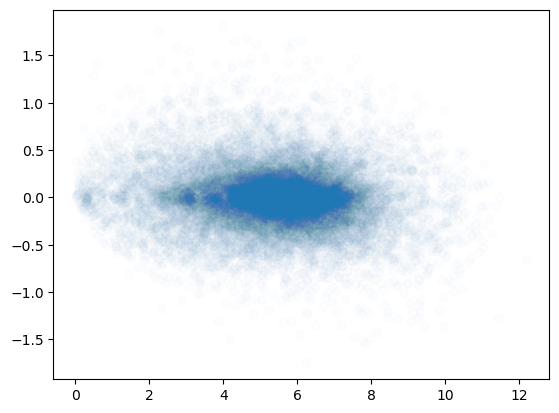

In [154]:
# acceleration - velocity for those trips
plt.scatter(gm.loc[gm_pass.index.unique().tolist()]["vel"], 
            gm.loc[gm_pass.index.unique().tolist()]["acc"], alpha=0.01)

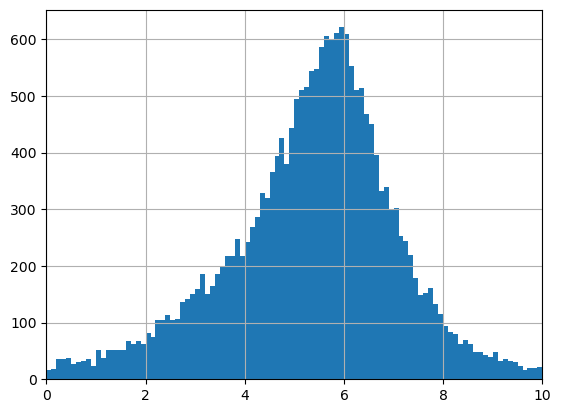

In [155]:
# velocity histogram for those trips
gm.loc[gm_pass.index.unique().tolist()]["vel"].hist(bins=[x/10 for x in range(210)])
#gm["vel"].hist(bins=[x/10 for x in range(210)],alpha=0.1)
plt.xlim([0,10])
plt.show()

In [156]:
gm_trans.head(2)

0         1         2     dev_0     dev_1     dev_2
52    12.323280  2.902212  9.522603  0.830419  9.704000  0.915746
2325   8.698326 -1.335785  5.661068  0.291992  5.926672  0.138887

In [157]:
gm_idx.head(2)

vel_mean  acc_mean  dec_mean      idle    cruise  acc_time    vel_max  \
52    6.168561  0.496441 -0.476042  0.492537  0.296020  0.350746  22.961251   
2325  9.763271  0.406365 -0.267855  0.057143  0.142857  0.457143  12.510265   

       acc_max   dec_min  
52    2.749240 -3.239572  
2325  1.238828 -0.688938

## Not sure about weighting the dev
look into more!
But regardless we assign each trip the combined deviance (weighted or not)

In [158]:
#we calculate the combined deviance (weighted) and transfer it back to the og dataframe gm
weight = pca.explained_variance_ratio_.tolist()

gm_trans["dev"] = gm_trans["dev_0"]*weight[0] + gm_trans["dev_1"]*weight[1] + gm_trans["dev_2"]*weight[2] #+ gm_trans["dev_3"]*weight[3]# + gm_trans["dev_4"] 

In [159]:
gm_idx["dev"] = gm_trans["dev"]
gm["dev"] = np.nan
gm.loc[gm.groupby(level=0).head(1).index, "dev"] = gm_idx["dev"].tolist()
gm["dev"].fillna(method="ffill",inplace=True)

We can see that the overlap between a trip having less than 10% deviance on each principal components (147 trips)
and that lowest total weighted deviance, is pretty significant  (These numbers are when we use MTs)

In [160]:
max_dev = gm.groupby(level=0)["dev"].mean().nsmallest(50).max()
gm_good = gm.loc[gm_pass.index.unique().tolist()].copy()
print("out of the fifty trips with the lowest weighted deviance", len(gm_good.loc[gm_good["dev"]<=max_dev].index.unique(level=0)), "of those have less than 10% deviance on any PC")
gm_good = gm_good.loc[gm_good["dev"]<=max_dev].copy()
#gm_good.groupby(level=0)["dev"].mean().nsmallest(8)

out of the fifty trips with the lowest weighted deviance 17 of those have less than 10% deviance on any PC


In [161]:
gm_good.groupby(level=0).head(1)

trajectory_id       id  id_origine.1  \
id_origine t                                                                  
310        2013-07-06 23:10:12.380016            390   177577           310   
643        2013-07-05 15:49:01.552518            952   416310           643   
732        2013-07-11 17:25:54.552518           1075   499552           732   
816        2013-07-12 09:53:59.552518           1213   577823           816   
919        2013-07-13 00:22:49.552518           1221   581666           919   
1287       2013-07-16 18:34:50.552518           1918   996624          1287   
1316       2013-07-16 23:11:13.552518           1924   999288          1316   
1532       2013-07-19 07:52:41.035012           2050  1065138          1532   
1926       2013-07-23 17:42:58.690008           2281  1194574          1926   
1868       2013-07-23 06:38:19.862510           2719  1445194          1868   
2017       2013-07-24 08:19:15.207514           3037  1605903          2017   
2343       2013-07-25 15:58:52.035012           3644  1902538          2343   
2565       2013-07-26 17:32:33.552518           4057  2129030          2565   
2901       2013-07-29 16:08:52.552518           4491  2451007          2901   
2999       2013-07-30 07:05:44.552518           4638  2523706          2999   
5726       2013-08-20 16:33:07.725020           5344  2904805          5726   
10290      2013-11-28 09:44:49.552518           5425  2948514         10290   

                                          length           purpose  \
id_origine t                                                         
310        2013-07-06 23:10:12.380016   6.511960            Social   
643        2013-07-05 15:49:01.552518   2.173893  Domicile-travail   
732        2013-07-11 17:25:54.552518  11.935984            Social   
816        2013-07-12 09:53:59.552518   6.996827      Work-related   
919        2013-07-13 00:22:49.552518   4.193918      Work-related   
1287       2013-07-16 18:34:50.552518   6.207224            Autres   
1316       2013-07-16 23:11:13.552518   6.262016           Commute   
1532       2013-07-19 07:52:41.035012   7.881847           Commute   
1926       2013-07-23 17:42:58.690008   0.100881  Domicile-travail   
1868       2013-07-23 06:38:19.862510   4.109594           Travail   
2017       2013-07-24 08:19:15.207514   6.715431      Work-related   
2343       2013-07-25 15:58:52.035012   3.500800           Courses   
2565       2013-07-26 17:32:33.552518   4.719259           Commute   
2901       2013-07-29 16:08:52.552518   8.254921           Commute   
2999       2013-07-30 07:05:44.552518   5.790040  Domicile-travail   
5726       2013-08-20 16:33:07.725020   5.049348  Domicile-travail   
10290      2013-11-28 09:44:49.552518   4.021704            School   

                                          duration                      dt  \
id_origine t                                                                 
310        2013-07-06 23:10:12.380016   877.031496  0 days 00:00:01.172502   
643        2013-07-05 15:49:01.552518  1140.844446  0 days 00:00:01.172502   
732        2013-07-11 17:25:54.552518  1789.238052  0 days 00:00:01.172502   
816        2013-07-12 09:53:59.552518   445.550760  0 days 00:00:01.172502   
919        2013-07-13 00:22:49.552518   667.153638  0 days 00:00:01.172502   
1287       2013-07-16 18:34:50.552518  1040.009274  0 days 00:00:01.172502   
1316       2013-07-16 23:11:13.552518   542.868426  0 days 00:00:01.172502   
1532       2013-07-19 07:52:41.035012  1330.789770  0 days 00:00:01.172502   
1926       2013-07-23 17:42:58.690008  1327.272264  0 days 00:00:01.172502   
1868       2013-07-23 06:38:19.862510  1424.589930  0 days 00:00:01.172502   
2017       2013-07-24 08:19:15.207514  4054.511916  0 days 00:00:01.172502   
2343       2013-07-25 15:58:52.035012  1044.699282  0 days 00:00:01.172502   
2565       2013-07-26 17:32:33.552518   605.011032  0 days 00:00:01.172502   
2901       2013-07-29 16:08:52.55251

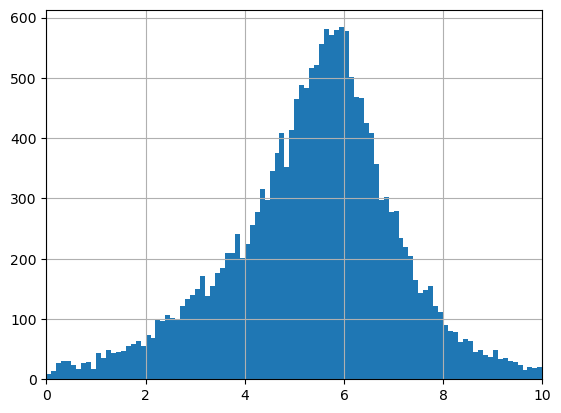

In [162]:
gm_good["vel"].hist(bins=[x/10 for x in range(200)])
plt.xlim([0,10])
plt.show()

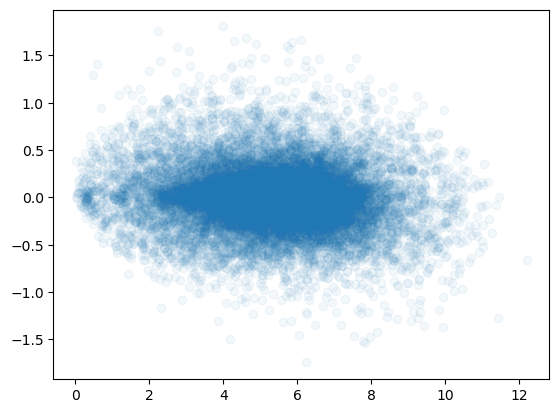

In [163]:
plt.scatter(gm_good["vel"], gm_good["acc"], alpha=0.05)

We can compare drawing a random trip from our good trips (frame)

In [164]:
idl = random.sample(gm_good.index.unique(level=0).tolist(), 1)

test = gm.loc[idl]
test_idx = gm_idx.loc[idl]

print("             new    OG")
print("mean vel:  ", round(test["vel"].mean(),2)," ", round(gm["vel"].mean(),2))
print("mean acc:  ", round(test["pos_acc"].mean(),2)," ", round(gm["pos_acc"].mean(),2))
print("mean dec:  ", round(test["neg_acc"].mean(),2), round(gm["neg_acc"].mean(),2))
print("% idle:    " , round(test_idx["idle"].mean(),2)," ", round(gm_idx["idle"].mean(),2))
print("% cruise:  ", round(test_idx["cruise"].mean(),2), " ", round(gm_idx["cruise"].mean(),2))
print("max vel:   ", round(test_idx["vel_max"].mean(),2)," ", round(gm_idx["vel_max"].mean(),2))
print("max acc:   ", round(test_idx["acc_max"].mean(),2)," ", round(gm_idx["acc_max"].mean(),2))
print("min dec:   ", round(test_idx["dec_min"].mean(),2)," ", round(gm_idx["dec_min"].mean(),2))

             new    OG
mean vel:   5.69   5.38
mean acc:   0.17   0.22
mean dec:   -0.16 -0.21
% idle:     0.01   0.09
% cruise:   0.5   0.36
max vel:    10.6   11.08
max acc:    1.68   1.33
min dec:    -1.16   -1.22


In [165]:
idl = random.sample(gm.index.unique(level=0).tolist(), 1)

test = gm.loc[idl]
test_idx = gm_idx.loc[idl]

print("             new    OG")
print("mean vel:  ", round(test["vel"].mean(),2)," ", round(gm["vel"].mean(),2))
print("mean acc:  ", round(test["pos_acc"].mean(),2)," ", round(gm["pos_acc"].mean(),2))
print("mean dec:  ", round(test["neg_acc"].mean(),2), round(gm["neg_acc"].mean(),2))
print("% idle:    " , round(test_idx["idle"].mean(),2)," ", round(gm_idx["idle"].mean(),2))
print("% cruise:  ", round(test_idx["cruise"].mean(),2), " ", round(gm_idx["cruise"].mean(),2))
print("max vel:   ", round(test_idx["vel_max"].mean(),2)," ", round(gm_idx["vel_max"].mean(),2))
print("max acc:   ", round(test_idx["acc_max"].mean(),2)," ", round(gm_idx["acc_max"].mean(),2))
print("min dec:   ", round(test_idx["dec_min"].mean(),2)," ", round(gm_idx["dec_min"].mean(),2))

             new    OG
mean vel:   4.9   5.38
mean acc:   0.14   0.22
mean dec:   -0.14 -0.21
% idle:     0.01   0.09
% cruise:   0.48   0.36
max vel:    7.67   11.08
max acc:    0.67   1.33
min dec:    -1.05   -1.22


In [166]:
gm_good.groupby(level=0)["duration"].mean().mean()/60

21.897049605882355

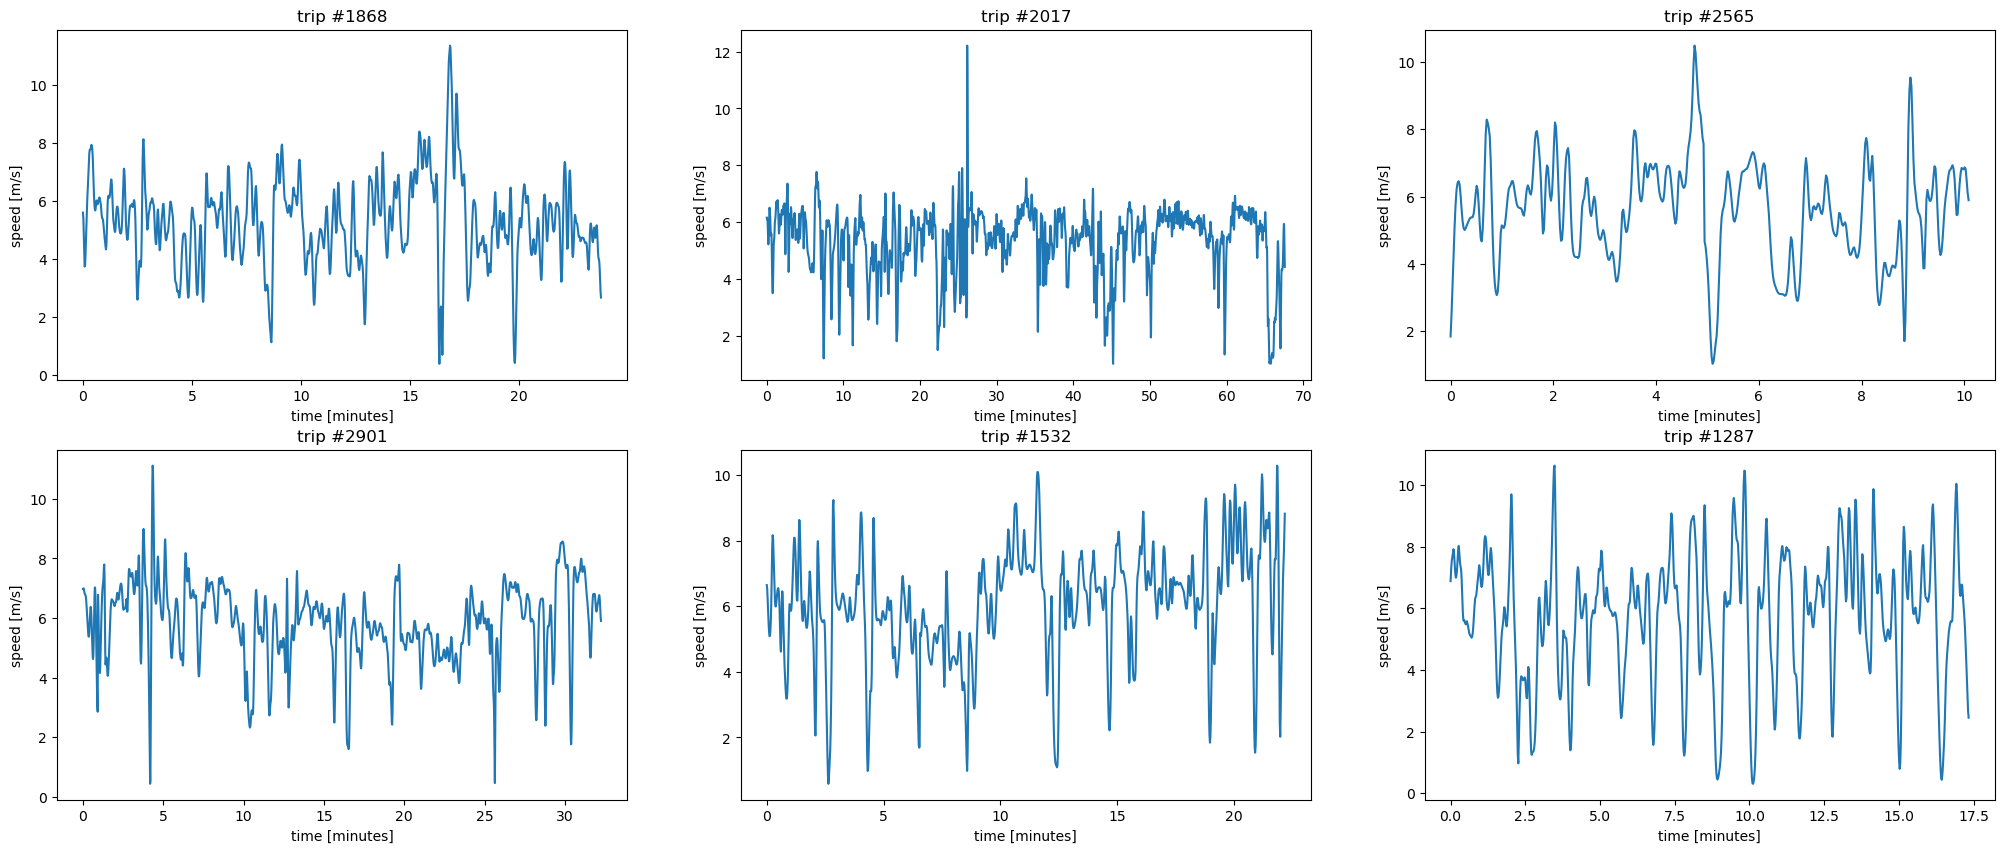

In [167]:
frame = gm_good
idx_long = frame.groupby(level=0)["dev"].mean().nsmallest(6).index.unique(level=0).tolist()


N = 6


fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = idx_long[i]
    times = [x/60 for x in gm.xs(trip)["timesum"].tolist()]
    vels = gm.xs(trip)["vel"].tolist()
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    #plt.xlim([0, 10])
    plt.title("trip #"+str(trip))

plt.show()

In [71]:
gm_good.loc[gm_good["duration"]<6*60].groupby(level=0)["dev"].mean().nsmallest(5).index

Index([4756], dtype='int64', name='og_idx')

# We can combine some of the best performing trips 
This is more relevant when we use MTs, since otherwise the trips will be very long \
\
This section was run with MTs

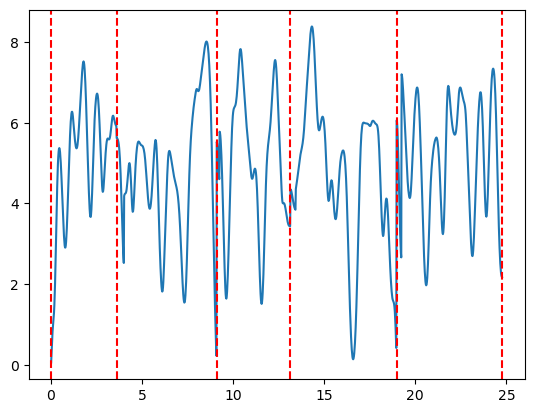

In [726]:
one_trip = gm.loc[gm_good.loc[gm_good["duration"]<6*60].groupby(level=0)["dev"].mean().nsmallest(5).index]


one_trip["timesum_tf"] = (one_trip["time"]/60).cumsum()
plt.plot(one_trip["timesum_tf"], one_trip["vel"])

one_trip["nt"] = 0
one_trip.loc[one_trip.groupby(level=0).head(1).index, "nt"] = 1
cut_plt = [x for x in one_trip["timesum_tf"]*one_trip["nt"].tolist() if x >0] + [one_trip["timesum_tf"].tolist()[-1]]
for xc in cut_plt:
    plt.axvline(x=xc, color="red", linestyle="--")
    
plt.show()


In [249]:
one_trip = gm_good.loc[frame.groupby(level=0)["dev"].mean().nsmallest(5).index.unique(level=0).tolist()].copy()

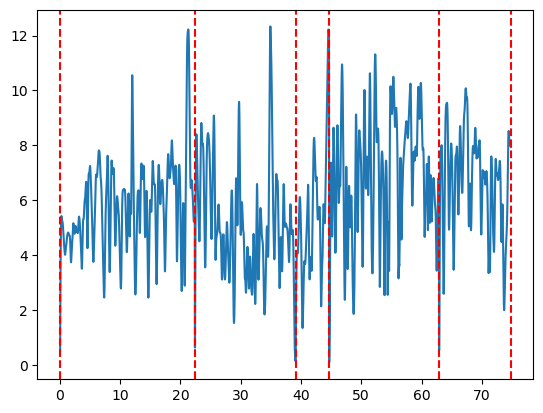

In [250]:
one_trip["timesum_tf"] = (one_trip["time"]/60).cumsum()
plt.plot(one_trip["timesum_tf"], one_trip["vel"])

one_trip["nt"] = 0
one_trip.loc[one_trip.groupby(level=0).head(1).index, "nt"] = 1
cut_plt = [x for x in one_trip["timesum_tf"]*one_trip["nt"].tolist() if x >0] + [one_trip["timesum_tf"].tolist()[-1]]
for xc in cut_plt:
    plt.axvline(x=xc, color="red", linestyle="--")
    
plt.show()

## Randomly plot N Mini-trips

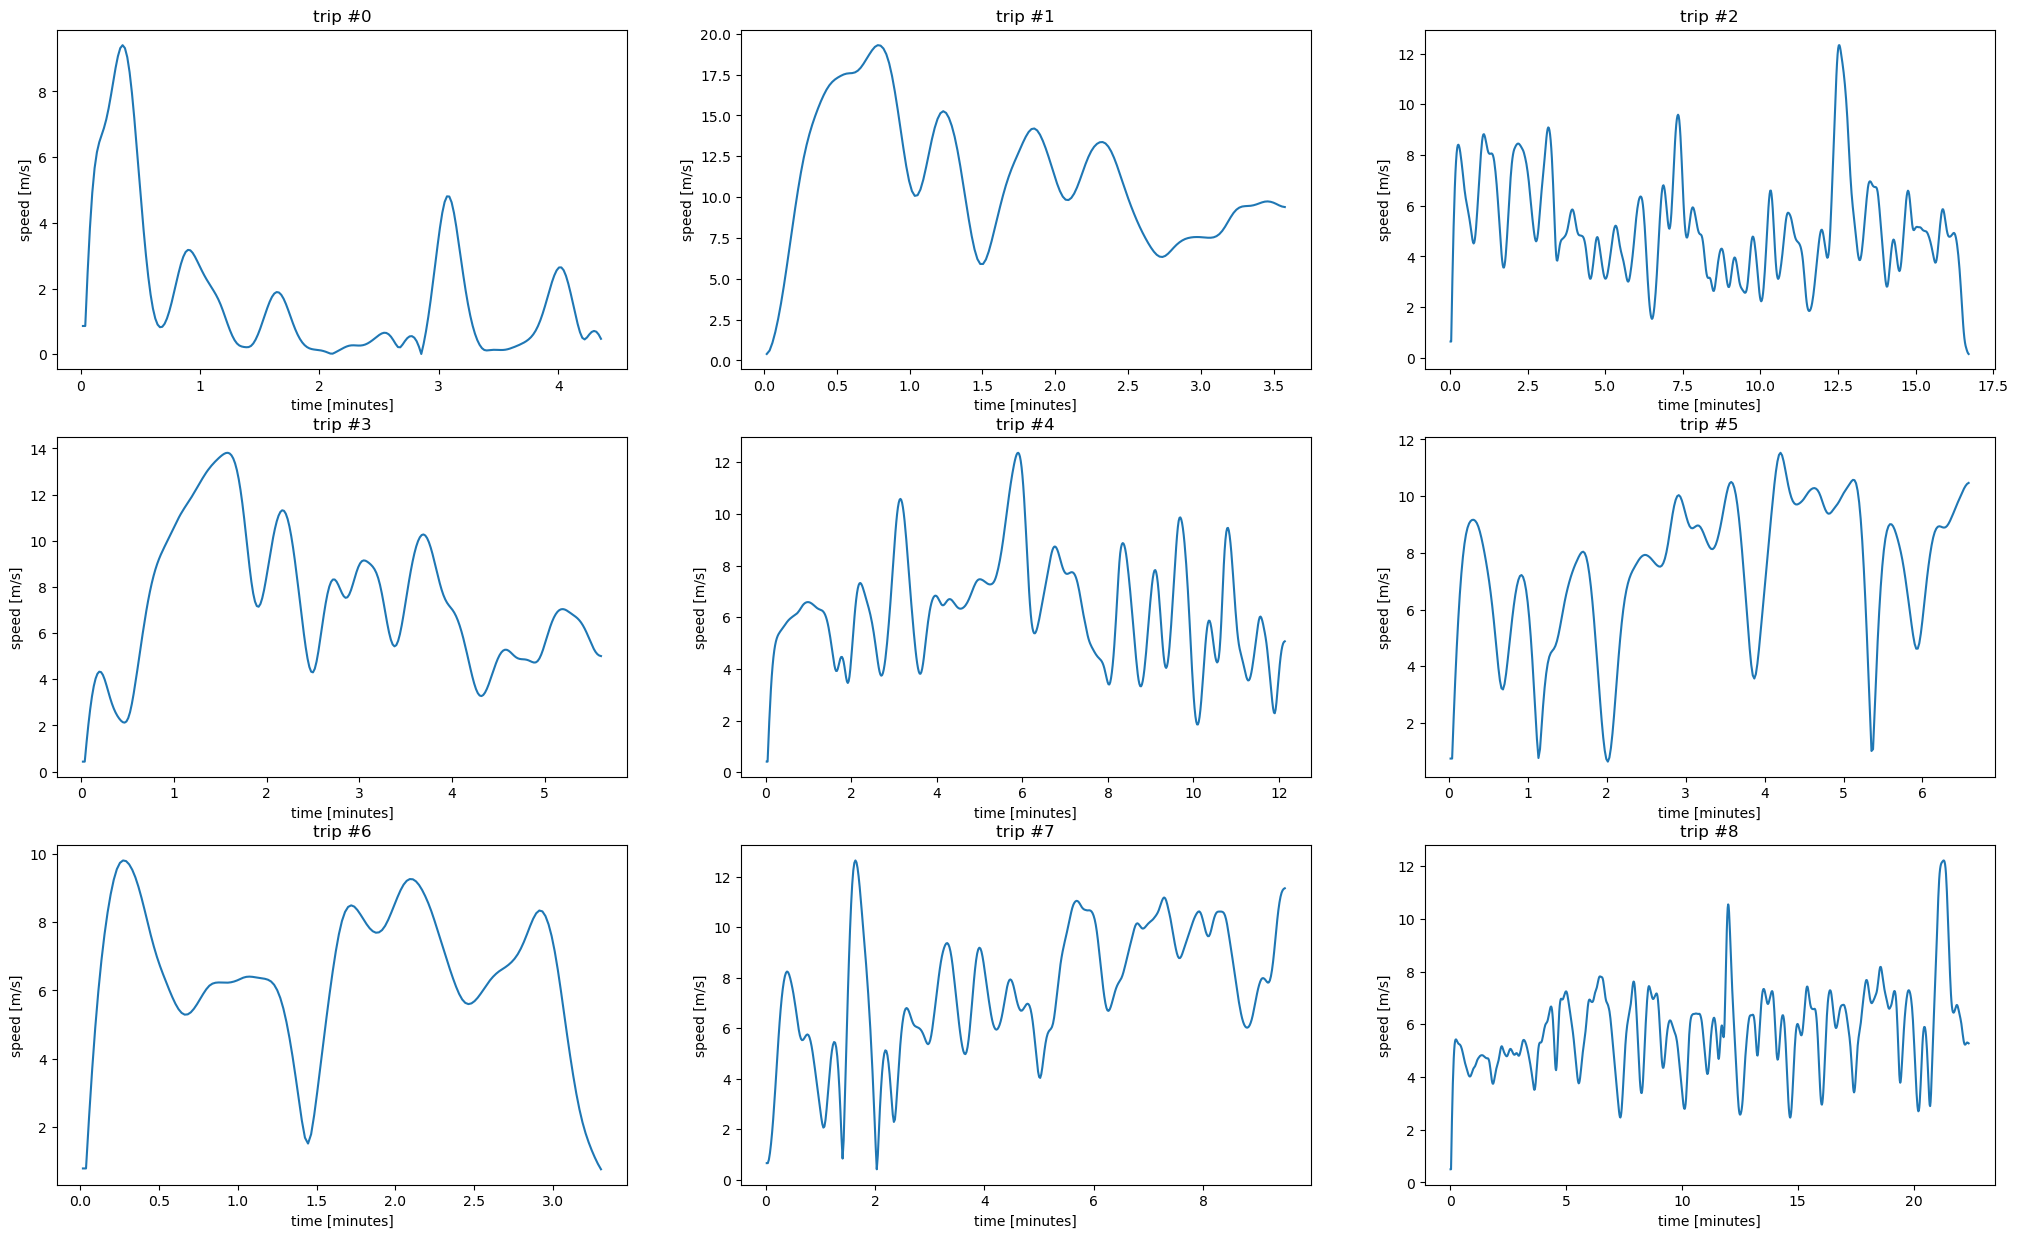

In [275]:
N = 9

trip_ids = gm.MT.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]


fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[i]#[trips[i]]
    times = [x/60 for x in gm.xs(trip)["timesum"].tolist()]
    vels = gm.xs(trip)["vel"].tolist()
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    #plt.xlim([0, 10])
    plt.title("trip #"+str(trip))

plt.show()

### Comparison conclusion
* These stats could be used in the optimization model
* We can compare a generated DC with either one of our best trips...
* ...or with a franken-trip constructed from good MTs
* My idea was basically to compare our DC to a franken-trip, based on parameters not optimized for

# Some stats that predates the above

In [72]:
tc_save = pd.read_csv('tc_save_part1.csv')
tc_save.set_index(["og_idx","t"],inplace=True)
tc_save = gpd.GeoDataFrame(tc_save)
tc_save["geometry"] = tc_save['geometry'].apply(wkt.loads)
tc_save.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [172]:
gdf = pd.read_csv('gdf_beforeKM.csv')
gdf.drop("id.1", axis=1, inplace=True)
gdf = gpd.GeoDataFrame(gdf)
gdf["geometry"] = gdf['geometry'].apply(wkt.loads)
gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')
gdf["vel"] = gdf["length"]/1.1725

In [173]:
gdf.loc[gdf["vel"]<0.2].groupby("id_origine").count()["vel"].nlargest(10)

id_origine
1525    396
842     350
3756    336
3203    325
663     319
2775    295
2812    244
3757    243
995     235
4169    224
Name: vel, dtype: int64

In [95]:
gdf.loc[gdf["id_origine"]==2328]

id  id_origine     length purpose  duration  \
1878526  1878526        2328   0.000000   Sport    4964.0   
1878527  1878527        2328  19.213861   Sport    4964.0   
1878528  1878528        2328   1.763806   Sport    4964.0   
1878529  1878529        2328  13.812780   Sport    4964.0   
1878530  1878530        2328   1.998727   Sport    4964.0   
...          ...         ...        ...     ...       ...   
1882211  1882211        2328   0.953040   Sport    4964.0   
1882212  1882212        2328   1.150927   Sport    4964.0   
1882213  1882213        2328   1.217843   Sport    4964.0   
1882214  1882214        2328   0.636321   Sport    4964.0   
1882215  1882215        2328  29.184934   Sport    4964.0   

                                                       geo  \
1878526  LINESTRING (-73.5717752815912 45.5188903739947...   
1878527  LINESTRING (-73.5717752815912 45.5188903739947...   
1878528  LINESTRING (-73.5715718580616 45.5187978448455...   
1878529  LINESTRING (-73.571550753 45.5187929096019, -7...   
1878530  LINESTRING (-73.57139183220001 45.518742785801...   
...                                                    ...   
1882211  LINESTRING (-73.5360187758 45.5214619171019, -...   
1882212  LINESTRING (-73.5360068735 45.5214630906019, -...   
1882213  LINESTRING (-73.5359932949 45.5214666948019, -...   
1882214  LINESTRING (-73.5359792971 45.5214711372019, -...   
1882215  LINESTRING (-73.5359716196065 45.5214727784347...   

                             dt                           t  trajectory_id  \
1878526  0 days 00:00:01.172502  2013-07-25 13:42:00.000000           3610   
1878527  0 days 00:00:01.172502  2013-07-25 13:42:01.172502           3610   
1878528  0 days 00:00:01.172502  2013-07-25 13:42:02.345004           3610   
1878529  0 days 00:00:01.172502  2013-07-25 13:42:03.517506           3610   
1878530  0 days 00:00:01.172502  2013-07-25 13:42:04.690008           3610   
...                         ...                         ...            ...   
1882211  0 days 00:00:01.172502  2013-07-25 14:54:00.669870           3610   
1882212  0 days 00:00:01.172502  2013-07-25 14:54:01.842372           3610   
1882213  0 days 00:00:01.172502  2013-07-25 14:54:03.014874           3610   
1882214  0 days 00:00:01.172502  2013-07-25 14:54:04.187376           3610   
1882215  0 days 00:00:01.172502  2013-07-25 14:54:05.359878           3610   

                           geometry        vel  
1878526  POINT (-73.57178 45.51889)   0.000000  
1878527  POINT (-73.57157 45.51880)  16.387088  
1878528  POINT (-73.57155 45.51879)   1.504312  
1878529  POINT (-73.57139 45.51874)  11.780622  
1878530  POINT (-73.57137 45.51873)   1.704671  
...                             ...        ...  
1882211  POINT (-73.53601 45.52146)   0.812827  
1882212  POINT (-73.53599 45.52147)   0.981601  
1882213  POINT (-73.53598 45.52147)   1.038672  
1882214  POINT (-73.53597 45.52147)   0.542704  
1882215  POINT (-73.53624 45.52130)  24.891202  

[3690 rows x 11 columns]

In [93]:
tc_save.xs(1773)["trajectory_id"].unique()

array([2328])

In [90]:
tc_save.xs(1773)

trajectory_id  og_idx.1     length purpose  \
t                                                                        
2013-07-25 13:42:19.045692           2328      1773   1.763806   Sport   
2013-07-25 13:42:28.568538           2328      1773  13.812780   Sport   
2013-07-25 13:42:38.091384           2328      1773   1.998727   Sport   
2013-07-25 13:42:47.614230           2328      1773   2.549433   Sport   
2013-07-25 13:42:57.137076           2328      1773   3.106101   Sport   
...                                   ...       ...        ...     ...   
2013-07-25 23:26:51.687510           2328      1773   0.953040   Sport   
2013-07-25 23:27:01.210356           2328      1773   1.150927   Sport   
2013-07-25 23:27:10.733202           2328      1773   1.217843   Sport   
2013-07-25 23:27:20.256048           2328      1773   0.636321   Sport   
2013-07-25 23:27:29.778894           2328      1773  29.184934   Sport   

                                duration                      dt  \
t                                                                  
2013-07-25 13:42:19.045692  35110.733202  0 days 00:00:09.522846   
2013-07-25 13:42:28.568538  35110.733202  0 days 00:00:09.522846   
2013-07-25 13:42:38.091384  35110.733202  0 days 00:00:09.522846   
2013-07-25 13:42:47.614230  35110.733202  0 days 00:00:09.522846   
2013-07-25 13:42:57.137076  35110.733202  0 days 00:00:09.522846   
...                                  ...                     ...   
2013-07-25 23:26:51.687510  35110.733202  0 days 00:00:09.522846   
2013-07-25 23:27:01.210356  35110.733202  0 days 00:00:09.522846   
2013-07-25 23:27:10.733202  35110.733202  0 days 00:00:09.522846   
2013-07-25 23:27:20.256048  35110.733202  0 days 00:00:09.522846   
2013-07-25 23:27:29.778894  35110.733202  0 days 00:00:09.522846   

                                              geometry       id       vel  \
t                                                                           
2013-07-25 13:42:19.045692  POINT (-73.57155 45.51879)  1878788  0.182489   
2013-07-25 13:42:28.568538  POINT (-73.57139 45.51874)  1878789  1.429116   
2013-07-25 13:42:38.091384  POINT (-73.57137 45.51873)  1878790  0.206795   
2013-07-25 13:42:47.614230  POINT (-73.57135 45.51872)  1878791  0.263773   
2013-07-25 13:42:57.137076  POINT (-73.57131 45.51871)  1878792  0.321367   
...                                                ...      ...       ...   
2013-07-25 23:26:51.687510  POINT (-73.53601 45.52146)  1882471  0.098606   
2013-07-25 23:27:01.210356  POINT (-73.53599 45.52147)  1882472  0.119080   
2013-07-25 23:27:10.733202  POINT (-73.53598 45.52147)  1882473  0.126004   
2013-07-25 23:27:20.256048  POINT (-73.53597 45.52147)  1882474  0.065837   
2013-07-25 23:27:29.778894  POINT (-73.53624 45.52130)  1882475  3.019607   

                                 acc      time       timesum  
t                                                             
2013-07-25 13:42:19.045692  0.130909  9.522846      0.000000  
2013-07-25 13:42:28.568538 -0.128357  9.522846      9.522846  
2013-07-25 13:42:38.091384  0.005983  9.522846     19.045692  
2013-07-25 13:42:47.614230  0.006048  9.522846     28.568538  
2013-07-25 13:42:57.137076 -0.001044  9.522846     38.091384  
...                              ...       ...           ...  
2013-07-25 23:26:51.687510  0.002150  9.522846  35072.641818  
2013-07-25 23:27:01.210356  0.000727  9.522846  35082.164664  
2013-07-25 23:27:10.733202 -0.006318  9.522846  35091.687510  
2013-07-25 23:27:20.256048  0.310177  9.522846  35101.210356  
2013-07-25 23:27:29.778894  0.000000  9.522846  35110.733202  

[3688 rows x 12 columns]

In [87]:
tc_save.loc[tc_save["vel"]<0.2].groupby(level=0).count()["vel"].nlargest(10)

og_idx
1773    2938
2134    1342
1757     937
874      638
3386     618
3174     600
460      598
1876     551
4356     519
1796     503
Name: vel, dtype: int64

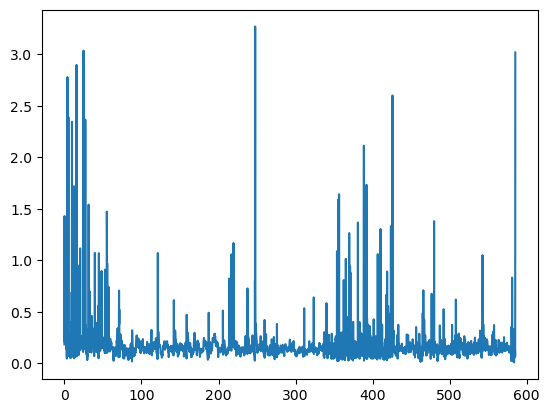

In [75]:
i = 1773
plt.plot(tc_save.loc[i]["timesum"]/60, tc_save.loc[i]["vel"])

In [185]:
gm.loc[gm["vel"]<0.2].groupby(level=0).count()["vel"].nlargest(10)

og_idx
862     503
3008    501
1137    479
3702    477
75      411
2219    300
1132    277
317     233
625     228
622     224
Name: vel, dtype: int64

## the vel dist
* There is some issue with the kalman filter
* I cannot fix it now - some dependencies have changed, but I'm on it.
* I do have other smoothers, which might be relevant

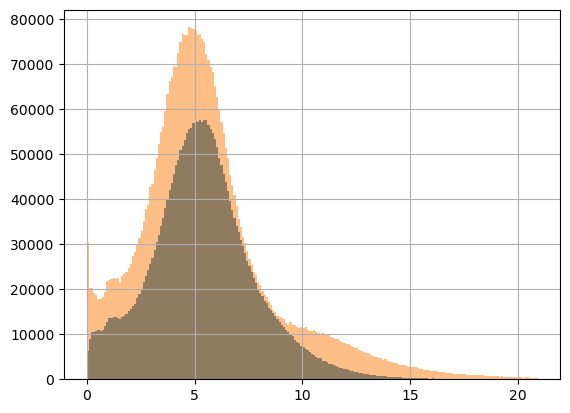

In [174]:
#gm_skew["vel"].hist(bins=[x/10 for x in range(210)])
gm["vel"].hist(bins=[x/10 for x in range(210)])
#tc_save["vel"].hist(bins=[x/10 for x in range(210)], alpha=0.5)
gdf["vel"].hist(bins=[x/10 for x in range(210)], alpha=0.5)
#plt.xlim([0,10])
plt.show()

# Elevation
* Currently we do not have this data saved, so skip

In [733]:
gm.head(2)

trajectory_id  id_origine    length  purpose  \
MT t                                                                          
1  2013-06-25 16:21:40.932534              0          52  9.913699  Commute   
   2013-06-25 16:21:42.105036              0          52  9.776124  Commute   

                               id    duration                     dt  \
MT t                                                                   
1  2013-06-25 16:21:40.932534  16  226.292886 0 days 00:00:01.172502   
   2013-06-25 16:21:42.105036  17  226.292886 0 days 00:00:01.172502   

                                                 geometry       vel  stop  \
MT t                                                                        
1  2013-06-25 16:21:40.932534  POINT (-73.57790 45.50811)  8.334226     0   
   2013-06-25 16:21:42.105036  POINT (-73.57784 45.50819)  8.330169     0   

                               ...  elev_start      acc   acc_in  MT  pos_acc  \
MT t                           ...                                              
1  2013-06-25 16:21:40.932534  ...   52.034226 -0.00346  0.08397   1      NaN   
   2013-06-25 16:21:42.105036  ...   51.658927 -0.09859 -0.00346   1      NaN   

                               neg_acc  cruise  acc_time       dev  idle  
MT t                                                                      
1  2013-06-25 16:21:40.932534 -0.00346       1         0  0.297275     0  
   2013-06-25 16:21:42.105036 -0.09859       1         0  0.297275     0  

[2 rows x 22 columns]

In [734]:
gm["elev_end"] = gm.groupby(level=0)["elev_start"].shift(periods=-1)
gm["elev_end"].fillna(method="ffill",inplace=True)

In [735]:
gm["slope"] = (gm["elev_end"]-gm["elev_start"])/gm["length"]
gm["slope"].fillna(0, inplace=True) #last point is nan

In [736]:
idl = np.abs((gm.groupby(level=0)["elev_start"].min() - gm.groupby(level=0)["elev_start"].max())).nlargest(500).index.tolist()
frame = gm.loc[idl]

In [737]:
#deg_gm = gm.loc[gm["length"]>0].sample(n=10000).copy()
#deg_gm["degree"] = np.arctan(deg_gm["slope"])

In [738]:
tc_save["elev_end"] = tc_save.groupby(level=0)["elev_start"].shift(periods=-1)
tc_save["elev_end"].fillna(method="ffill",inplace=True)
tc_save["slope"] = (tc_save["elev_end"]-tc_save["elev_start"])/tc_save["length"]
tc_save["slope"].fillna(0, inplace=True) #last point is nan

In [739]:
#uncomment the first thrree to plot for un-smoothed data
#uncomment the last three for data through kalmanfilter

idl = np.abs((tc_save.groupby(level=0)["elev_start"].min() - tc_save.groupby(level=0)["elev_start"].max())).nlargest(500).index.tolist()
frame = tc_save.loc[idl]
gm_deg = tc_save.loc[idl].copy()

#idl = np.abs((gm.groupby(level=0)["elev_start"].min() - gm.groupby(level=0)["elev_start"].max())).nlargest(500).index.tolist()
#gm_deg = gm.loc[idl].copy()
#frame = gm.loc[idl]

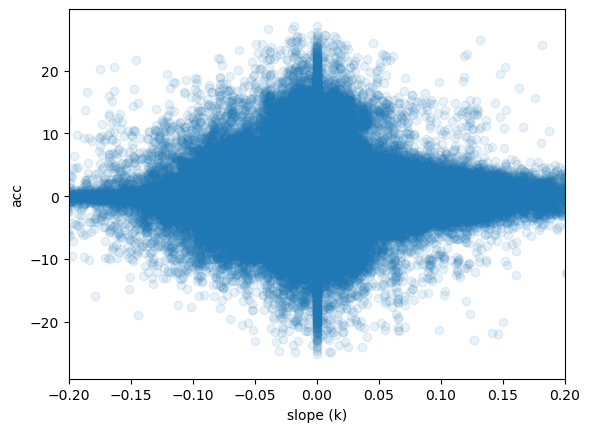

In [740]:
plt.scatter(frame.loc[frame["length"]>0]["slope"], frame.loc[frame["length"]>0]["acc"], alpha=0.1)
plt.xlim([-0.2,0.2])
plt.xlabel("slope (k)")
plt.ylabel("acc")
plt.show()

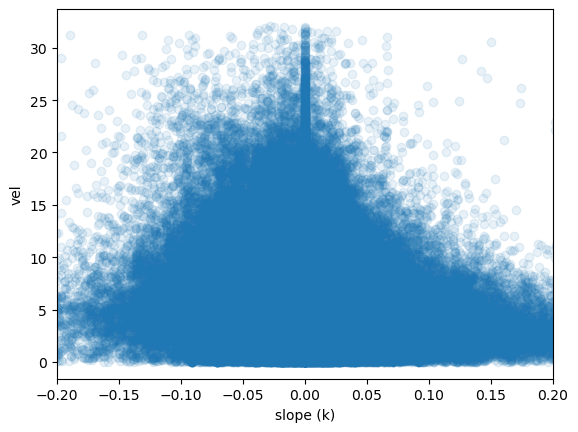

In [741]:
plt.scatter(frame.loc[frame["length"]>0]["slope"], frame.loc[frame["length"]>0]["vel"], alpha=0.1)
plt.xlim([-0.2,0.2])
plt.xlabel("slope (k)")
plt.ylabel("vel")
plt.show()

In [175]:
#Here we simply set the bin-sizes for the average speed
variable = "slope"  
grouped_variable_name = "slope_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(-10,11):
    bin_edges.append(i/(50))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(-10,11):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm[grouped_variable_name] = pd.cut(
    gm[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

KeyError: 'slope'

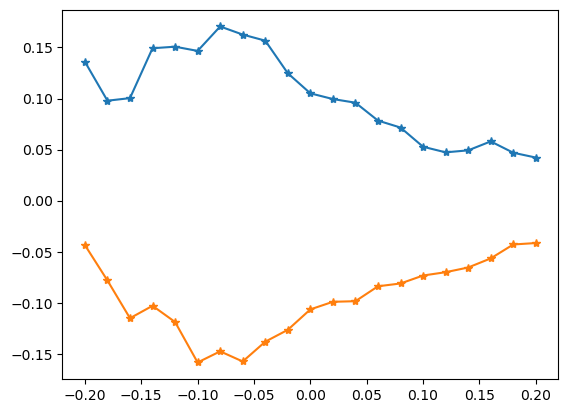

In [743]:
x = [y/50 for y in gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].quantile(0.7).index.tolist()]
y = gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].quantile(0.7).tolist()
plt.plot(x,y, "-*")

x = [y/50 for y in gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].quantile(0.3).index.tolist()]
y = gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].quantile(0.3).tolist()
plt.plot(x,y, "-*")

plt.show()

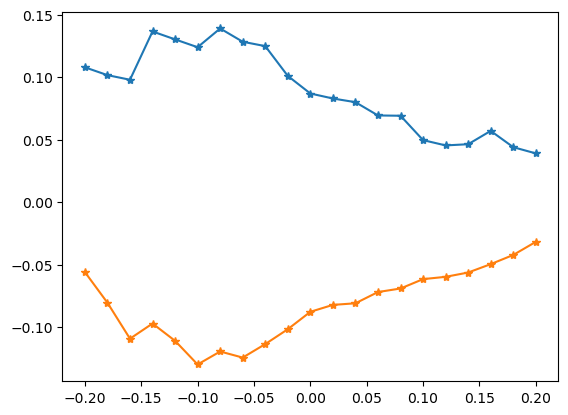

In [744]:
x = [y/50 for y in gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].mean().index.tolist()]
y = gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].mean().tolist()
plt.plot(x,y, "-*")

x = [y/50 for y in gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].mean().index.tolist()]
y = gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].mean().tolist()
plt.plot(x,y, "-*")

plt.show()

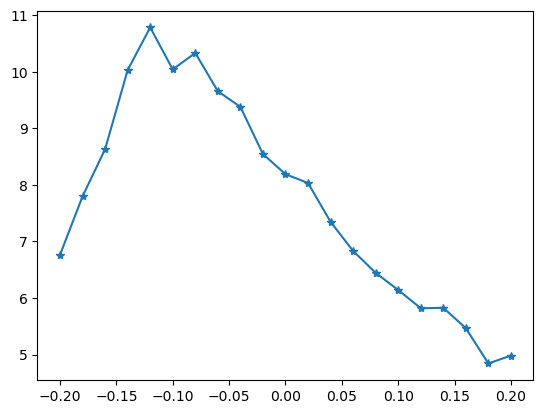

In [745]:
x = [y/50 for y in gm.groupby("slope_bin")["vel"].quantile(0.7).index.tolist()]
y = gm.groupby("slope_bin")["vel"].quantile(0.9).tolist()
plt.plot(x,y, "-*")


plt.show()

# Acceleration
Lets look how acceleration works
We compare tc_save with gm (i.e. unprocesses vs smoothed)

In [127]:
gm_stat = gm.loc[gm["acc"]>=0][["vel", "acc"]].copy()

In [128]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm_stat[grouped_variable_name] = pd.cut(
    gm_stat[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [129]:
gm_dec = gm.loc[gm["acc"]<=0][["vel", "acc"]].copy()

In [130]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm_dec[grouped_variable_name] = pd.cut(
    gm_dec[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [131]:
#Here we simply set the bin-sizes for the average acc
variable = "acc"  
grouped_variable_name = "acc_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,26):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,26):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm_stat[grouped_variable_name] = pd.cut(
    gm_stat[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [132]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
tc_save[grouped_variable_name] = pd.cut(
    tc_save[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

NameError: name 'tc_save' is not defined

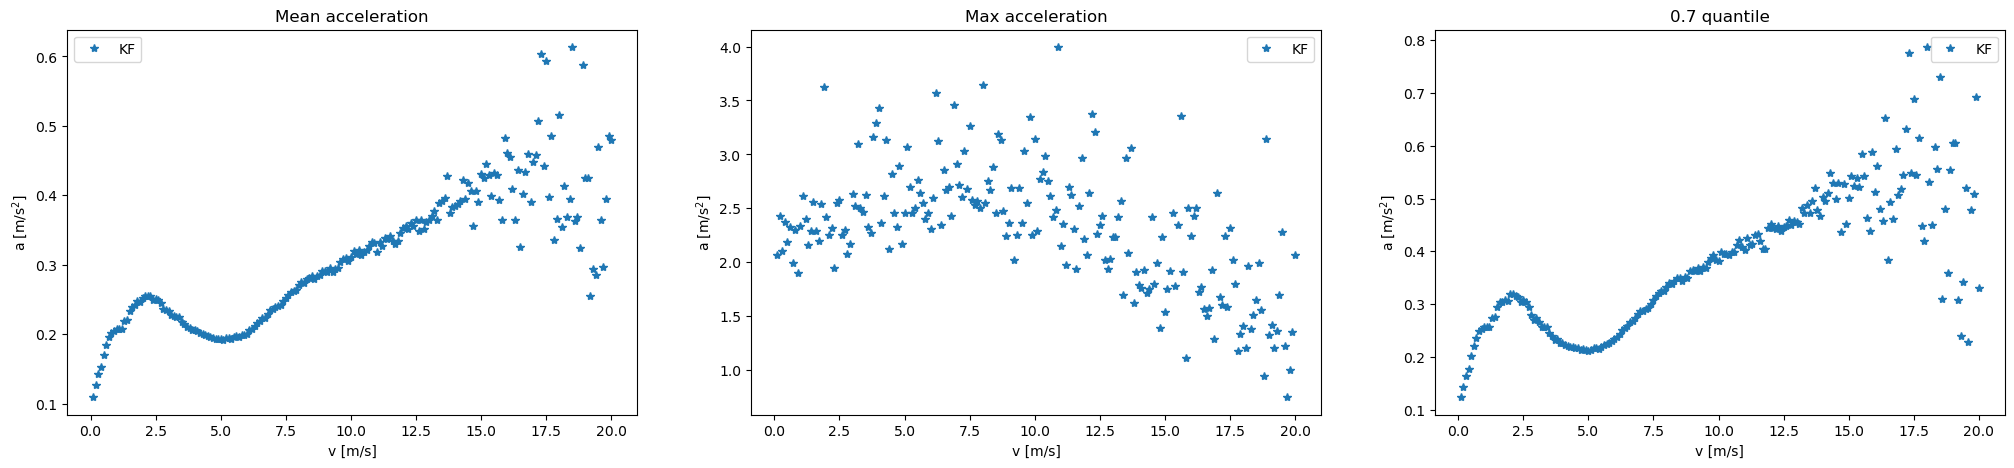

In [133]:
#tc_plt = tc_save.reset_index(drop=True).copy()
gm_plt = gm_stat.reset_index(drop=True).copy()

fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], gm_plt.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="KF")
#plt.plot([x/10 for x in range(1,201)], tc_plt.loc[tc_plt["acc"]>=0].groupby("vel_bin")["acc"].agg(["mean"]), "*", label="OG")
#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5")

plt.legend()
plt.plot()
plt.title("Mean acceleration")

plt.subplot(1,3,2)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in gm_plt.groupby("vel_bin")["acc"].nlargest(1).index.unique(level=0).tolist()], gm_plt.groupby("vel_bin")["acc"].nlargest(1), "*", label="KF")
#plt.plot([x/10 for x in tc_plt.loc[(tc_plt["acc"]>=0) &(tc_plt["vel"]<20)].groupby("vel_bin")["acc"].nlargest(1).index.unique(level=0).tolist()], tc_plt.loc[tc_plt["acc"]>=0].groupby("vel_bin")["acc"].nlargest(1), "*", label="OG")
#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="lfilter, n=5")
plt.legend()
plt.title("Max acceleration")

#plt.subplot(1,3,3)
#plt.xlabel("v [m/s]")
#plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], gm_plt.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="KF")
#plt.plot([x/10 for x in range(1,201)], tc_plt.loc[(tc_plt["acc"]>=0)  &(tc_plt["vel"]<20)].groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="OG")
#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="lfilter, n=5")

plt.subplot(1,3,3)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], gm_plt.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)), "*", label="KF")
#plt.plot([x/10 for x in range(1,201)], tc_plt.loc[(tc_plt["acc"]>=0)  &(tc_plt["vel"]<20)].groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)), "*", label="OG")
#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="lfilter, n=5")


#plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.legend()
plt.title("0.7 quantile")


plt.show()

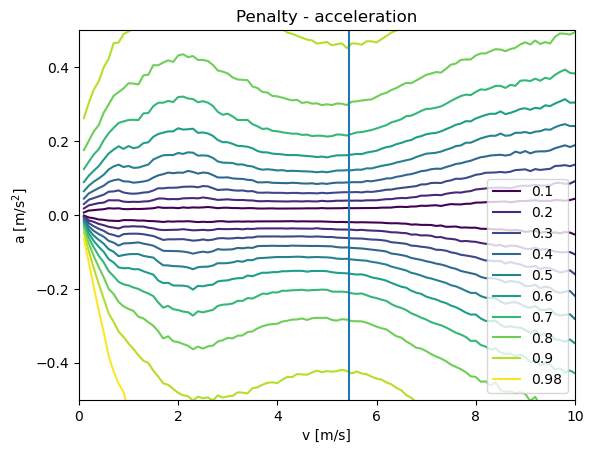

In [136]:
gm_plt_a = gm_stat.reset_index(drop=True).copy()
gm_plt_d = gm_dec.reset_index(drop=True).copy()

plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")


color=mcp.gen_color(cmap="viridis",n=10)


#print("quant: acc")
acc_l = []
for i in range(9):
    q = (i + 1)/10

    plt.plot([x/10 for x in range(1,201)], gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q)), "-", label=str(q), color=color[i])
    plt.plot([x/10 for x in range(1,201)], gm_plt_d.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(1-q)), "-", color=color[i])
    accc = round(gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q))[53],2)
    acc_l.append(accc)
    #print(q,":", accc)

q=0.98
plt.plot([x/10 for x in range(1,201)], gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q)), "-", label=str(q), color=color[-1])
plt.plot([x/10 for x in range(1,201)], gm_plt_d.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(1-q)), "-", color=color[-1])

plt.vlines([gm["vel"].mean()],-0.5,0.5)
plt.xlim([0,10])
plt.ylim([-0.5,0.5])
plt.legend()
plt.plot()
plt.title("Penalty - acceleration")


plt.show()

In [1]:
gm_clean_save = gm[["vel","acc"]].copy()
gm_clean_save.reset_index(drop=True, inplace=True)
gm_clean_save

NameError: name 'gm' is not defined

In [142]:
gm_clean_save.to_csv("gm_clean_may14.csv")

0.9


Text(0.5, 1.0, 'Mean acceleration')

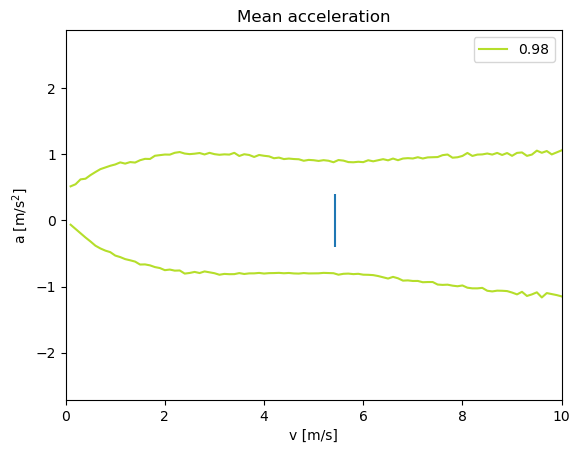

In [137]:
gm_plt_a = gm_stat.reset_index(drop=True).copy()
gm_plt_d = gm_dec.reset_index(drop=True).copy()

plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")


color=mcp.gen_color(cmap="viridis",n=10)


q = 0.98

plt.plot([x/10 for x in range(1,201)], gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q)), "-", label=str(q), color=color[i])
plt.plot([x/10 for x in range(1,201)], gm_plt_d.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(1-q)), "-", color=color[i])
accc = round(gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q))[53],2)
print(accc)
plt.vlines([gm["vel"].mean()],-0.4,0.4,)

plt.xlim([0,10])
#plt.ylim([-0.4,0.4])
plt.legend()
plt.plot()
plt.title("Mean acceleration")

# After optimization

In [107]:
import pickle

# Okay
The idea is to compare the results to some other stuff. The things to compare is
* OPT physics
* OPT constant
* OPT data

* Random
* best of five random trips



How to do this? 
* Should we use OG data or smoothed? Should we smooth after the fact? It feels wrong to not use OG data since we are using an acceleration function based on OG data. 
* Should we cut all histograms off over 10 m/s? Because otherwise they are hard to compare to each other. But then how to we compare that to the random trips we choose? Actually, this is not a problem for the 5 random trips choosen. But keep in mind.

## Plan
First issue, the trips have a timestep op 1.51 seconds. We would like to change this so that it is 2 seconds. OR we just scale the histograms so that

# this is the histogram we are working with!!!

OG data 

In [255]:
H_scaled = [4.512743388441156, 4.273652521789638, 4.076151085825884, 4.050617109775722, 3.776513745661481, 3.751560087248823, 3.8283554546118106, 4.079439552438405, 4.4003552059779425, 4.422213836990581, 4.6798748680422175, 4.7874270701929005, 4.483534067353471, 4.657822797817078, 4.727654353530021, 4.802902207192999, 4.942371879406385, 5.279923305221028, 5.383219844696684, 5.770872026549146, 6.177287812014226, 6.458935305416015, 6.8469743656934785, 7.375450294246835, 7.64394392119854, 8.330266247152897, 8.749062142218058, 9.519143647185448, 10.012607078276082, 10.561394124142065, 11.172081718008444, 11.865174416400345, 12.09285236951429, 12.838173655281523, 13.359685772184836, 13.770163781112442, 14.083922183789435, 14.604273665417738, 15.27705524649701, 15.54477511659871, 15.851569707625659, 15.914050573263555, 15.973242972288931, 16.013478328489185, 16.06783474720203, 15.7792234421502, 15.812688425912912, 15.61866889577418, 15.558702739898798, 15.046282265983045, 14.85980686513186, 14.618975045567831, 13.858372062013002, 13.710777942874564, 13.332023964797159, 12.778400938618644, 12.2990585700406, 11.783349629512326, 11.448893231097701, 10.731040313505643, 10.260015831065152, 9.876425872675217, 9.318547183821673, 8.845201430831167, 8.550593510191797, 8.010124350463364, 7.583590886898157, 7.294786142633822, 6.818925679880801, 6.469574462103583, 6.128734569676418, 5.814202410149421, 5.542226877372694, 5.231176623670718, 4.926703303193785, 4.695156565829815, 4.529379160716262, 4.274619717852144, 4.242895687001942, 3.923527547162415, 3.7165475897861002, 3.6716696924858154, 3.510341389259791, 3.390602516721531, 3.1905863709952604, 3.174917794782661, 2.982058899918936]
vel = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6]

# Random

In [256]:
random_route = []
vel_list = [round(x) for x in H_scaled]

for i in range(len(vel_list)):
    v_curr = vel[i]
    for j in range(vel_list[i]):
        random_route.append(v_curr)
random.shuffle(random_route)

rand_df = pd.DataFrame(random_route, columns=['vel'])
rand_df["time"] = [2*x for x in range(len(random_route))]
rand_df["vel_smooth"] = rand_df["vel"].rolling(5).mean()

v_use = ["vel", "vel_smooth"]
acc_name = ["acc", "acc_smooth"]
for i in range(2):
    rand_df[acc_name[i]] = -rand_df[v_use[i]].diff(periods=-1)
    rand_df[acc_name[i]] = rand_df.loc[:, (acc_name[i])]/2

rand_df.dropna(inplace = True)

variable = "vel_smooth"  
grouped_variable_name = "vel_smooth_bin"

rand_df[grouped_variable_name] = pd.cut(
    rand_df[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [257]:
rand_df.head(2)

vel  time  vel_smooth  acc  acc_smooth vel_smooth_bin
4  3.4     8        3.80  0.7        0.27             38
5  4.8    10        4.34 -1.4       -0.37             43

<BarContainer object of 87 artists>

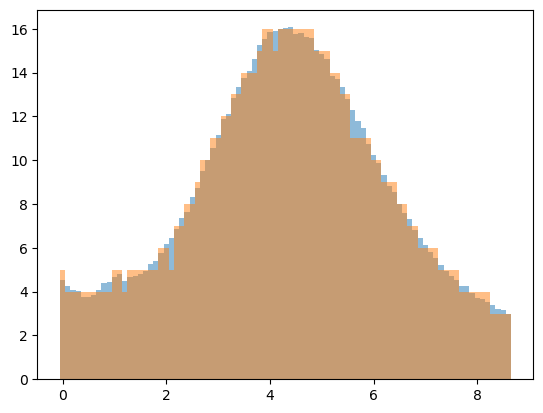

In [258]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data", width=0.1)
plt.bar(vel, rand_df.groupby("vel")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

# random trips

In [259]:
trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()

NameError: name 'GM' is not defined

In [1319]:
N_trip = 3
trips = [1011, 91, 915, 1390, 1192] #random

trips_df_list = []
for i in range(N_trip):
    trip = trips[i]
    trips_df = pd.DataFrame(GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)]["time_sum"].tolist(), columns=['time_sum'])
    cols = ["vel", "acc", "vel_smooth", "acc_smooth", "vel_bin", "vel_OG_bin"]

    for col in cols:
        trips_df[col] = GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)][col].tolist()

    trips_df.rename(columns={'vel_bin': 'vel_smooth_bin'}, inplace=True)
    trips_df.rename(columns={'vel_OG_bin': 'vel_bin'}, inplace=True)
    trips_df_list.append(trips_df)

In [1320]:
trips_df_list[0].head(3)

time_sum       vel       acc  vel_smooth  acc_smooth  vel_smooth_bin  \
0  0.000000  3.618448  0.091599    2.982183    0.252267              30   
1  0.025167  3.756762  2.153695    3.363106    0.549318              34   
2  0.050333  7.008841 -2.242281    4.192577    0.056646              42   

   vel_bin  
0       37  
1       38  
2       71

## Compare the three trips here

we need to scale the histogram so that it matches sum(H_trips) instead of 750

In [1321]:
c = 994/750
H_trips = [x*c for x in H_scaled]

In [1466]:
tr = 2
trips_df = trips_df_list[tr]

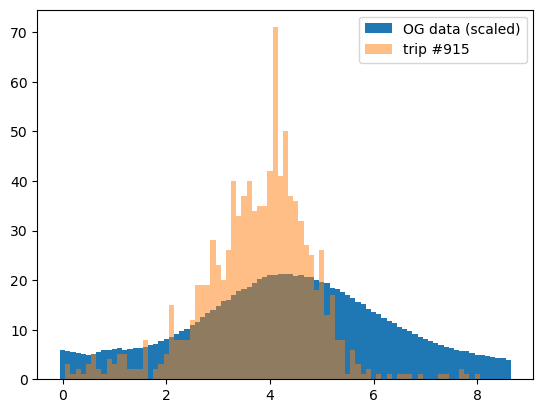

In [1470]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data (scaled)", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="trip #"+str(trips[tr]), width=0.1, alpha = 0.5)
#plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

We can combine their velocities into one histogram (and scale it to 750)

In [1503]:
comb_H = [0 for x in range(100)]

for trips_df in trips_df_list:
    h = trips_df.groupby("vel_bin")["vel_bin"].count().reindex([x for x in range(100)], fill_value=0)
    for i in range(100):
        comb_H[i] += h[i]/N_trip

c = 750/sum(comb_H)
comb_H = [x*c for x in comb_H]
print("scaled:", round(sum(comb_H)), round(sum(H_scaled)))

scaled: 750 750


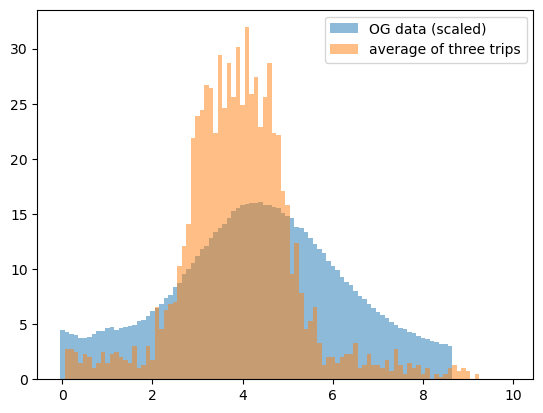

In [1471]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H, label="average of three trips", alpha=0.5, width=0.1)
plt.legend()
plt.show()

# One trip

In [260]:
variable = "vel"  
grouped_variable_name = "vel_bin"

gm_good[grouped_variable_name] = pd.cut(
    gm_good[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [261]:
variable = "vel"  
grouped_variable_name = "vel_bin"

one_trip[grouped_variable_name] = pd.cut(
    one_trip[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [262]:
variable = "vel"  
grouped_variable_name = "vel_bin"

gm[grouped_variable_name] = pd.cut(
    gm[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [263]:
gm_c = np.sum(gm.groupby("vel_bin")["vel"].count().tolist()[0:-1])
ot_c = np.sum(one_trip.groupby("vel_bin")["vel"].count().tolist())
scale_ot = gm_c/ot_c

In [264]:
gm_c = np.sum(gm.groupby("vel_bin")["vel"].count().tolist()[0:-1])
good_c = np.sum(gm_good.groupby("vel_bin")["vel"].count().tolist())
scale_good = gm_c/good_c

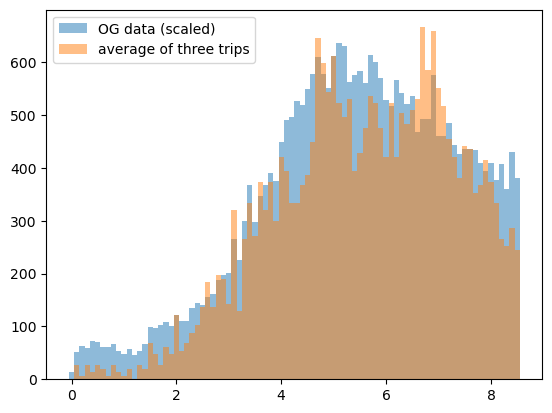

In [266]:
plt.bar(vel[0:-1], gm.groupby("vel_bin")["vel"].count().tolist()[0:-1],alpha=0.5,label="OG data (scaled)", width=0.1)
#plt.bar(vel, (one_trip.groupby("vel_bin")["vel"].count()*scale_ot).tolist(), label="average of three trips", alpha=0.5, width=0.1)
plt.bar(vel[0:-1], (gm_good.groupby("vel_bin")["vel"].count()*scale_good).tolist()[0:-1], label="average of three trips", alpha=0.5, width=0.1)

plt.legend()
plt.show()



# optimized trip

In [267]:
#runs = ["phys_wStops", "phys_noStops", "phys_wStops_OG", "const_cut_87_OG"]
runs = ["OPT_physics", "OPT_constant", "OPT_data"]
#runs = ["phys_wStops_OG", "const_cut_87_OG", "dist_cut_87_OG"]
#runs = ["OPT_physics", "phys_wStops_OG"]
opt_df_list = []

for name in runs:
    with open("pickle/"+name+".pickle", 'rb') as handle: #open
        x_val_dic = pickle.load(handle)

    x_val = x_val_dic[0][1::] #the first elem in list is opt-val - not a velocity
    opt_df = pd.DataFrame(x_val, columns=['vel'])
    opt_df["time"] = [2*x for x in range(len(x_val))]


    opt_df["vel_smooth"] = opt_df["vel"].rolling(5).mean()

    v_use = ["vel", "vel_smooth"]
    acc_name = ["acc", "acc_smooth"]
    for i in range(2):
        opt_df[acc_name[i]] = -opt_df[v_use[i]].diff(periods=-1)
        opt_df[acc_name[i]] = opt_df.loc[:, (acc_name[i])]/2

    opt_df.dropna(inplace = True)

    variable = "vel_smooth"  
    grouped_variable_name = "vel_smooth_bin"

    opt_df[grouped_variable_name] = pd.cut(
        opt_df[variable],
        bins= vel + [np.inf],
        labels= [x for x in range(len(vel))],
        right=False) 
    opt_df_list.append(opt_df)

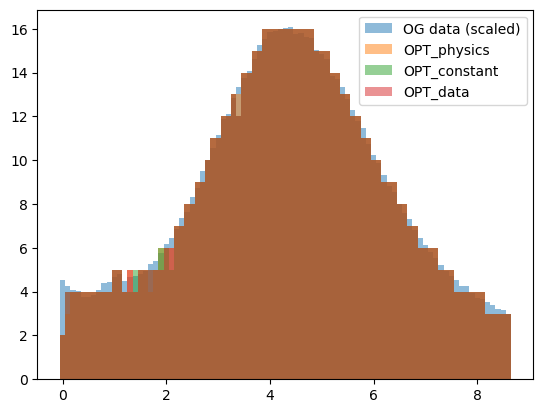

In [268]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
for i in range(len(runs)):
    opt_df = opt_df_list[i]
    lab = runs[i]
    plt.bar(vel, opt_df.groupby("vel")["vel"].count().tolist(), label=lab,alpha=0.5,width=0.1)
plt.legend()
plt.show()


# Compare

In [269]:
print("mean velocity:")
print("OG data:", round(gm.loc[gm["vel"]<=8.6]["vel"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel"].mean(),2))
print("random:", round(rand_df["vel"].mean(),2))
print("one trip:", round(one_trip["vel"].mean(),2))
#print("three trips:", round((trips_df_list[0]["vel"].mean() + trips_df_list[1]["vel"].mean() + trips_df_list[2]["vel"].mean())/3,2))


mean velocity:
OG data: 5.46
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.35
one trip: 6.01


In [270]:
one_trip.rename(columns={"acc":"acc"},inplace=True)
gm.rename(columns={"acc":"acc"},inplace=True)

In [273]:
list_name = opt_df_list + [gm.loc[gm["vel"]<=8.6], rand_df, one_trip]
names = runs + ["OG", "RANDOM", "one_trip"]
acc_time = []
dec_time = []
cruise_time = []
N_trip=3

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)

list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)
            

In [274]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 46.31 %
OPT_constant 53.83 %
OPT_data 50.2 %
OG 27.36 %
RANDOM 46.19 %
one_trip 28.26 %

time spent decelerating:
OPT_physics 30.47 %
OPT_constant 33.29 %
OPT_data 36.91 %
OG 25.12 %
RANDOM 46.6 %
one_trip 27.34 %

time spent cruising:
OPT_physics 23.22 %
OPT_constant 12.89 %
OPT_data 12.89 %
OG 47.52 %
RANDOM 7.21 %
one_trip 44.4 %


## number of stops
Since I've all but dropped "smoothed" data, the number of stops should now instead be defined from the OG data. So the number of stops *should* be 31.. (we could also check whether the smoothed OPT is close to 9 stops?)

In [1511]:
#state 0 means we are in a "stop-period"
#state 1 means we are in a "drive-period"

max_vel = 2#limit for what is considered "stop"
velocities = opt_df_list[0]["vel"].tolist()
stops = []    #list to save all stop-periods

state = 1     #we start in a drive-period (I know this because I know the data, might have to change if other data is used)
one_stop = [] #list to save all velocities for one stop-period




for i in range(1, len(velocities)): 
    v = velocities[i]                  #current vel
    
    if state == 0 and v < max_vel:    #we are in a stop-period and we stay there
        one_stop.append(v)             #keep adding "stop-period"-velocities, 
        #state = 0                     #stay in state
        
    elif state == 0 and v >= max_vel:   #we are leaving a stop-period
        one_stop.append(v)         #add vel *just after* stop-period
        stops.append(one_stop)     #save this stop
        state = 1                  #change state
            
    elif state == 1 and v < max_vel:   #we are entering a stop-period
        one_stop = [velocities[i-1], v]#add vel *just before* stop-period AND first vel *in* stop-period
        state = 0
    else: #state = 1 v > 1
        state = 1
print(len(stops))

31


##  stops
* All OPTs has (predictably) 31 stops
* random has 82
* trip 1: 13, trip 2: 16, trip 3: 18

# anything else to compare?

* speed vs acceleration?

In [1512]:
opt_df

vel  time  vel_smooth   acc  acc_smooth vel_smooth_bin
4    2.7     8        1.94  0.40        0.35             19
5    3.5    10        2.64  0.45        0.29             26
6    4.4    12        3.22  0.40        0.30             32
7    5.2    14        3.82  0.15        0.22             38
8    5.5    16        4.26 -1.75       -0.07             42
..   ...   ...         ...   ...         ...            ...
744  3.6  1488        3.48  0.40        0.01             34
745  4.4  1490        3.50 -0.25        0.06             35
746  3.9  1492        3.62 -0.15        0.07             36
747  3.6  1494        3.76  0.20        0.07             37
748  4.0  1496        3.90 -2.00       -0.36             39

[745 rows x 6 columns]

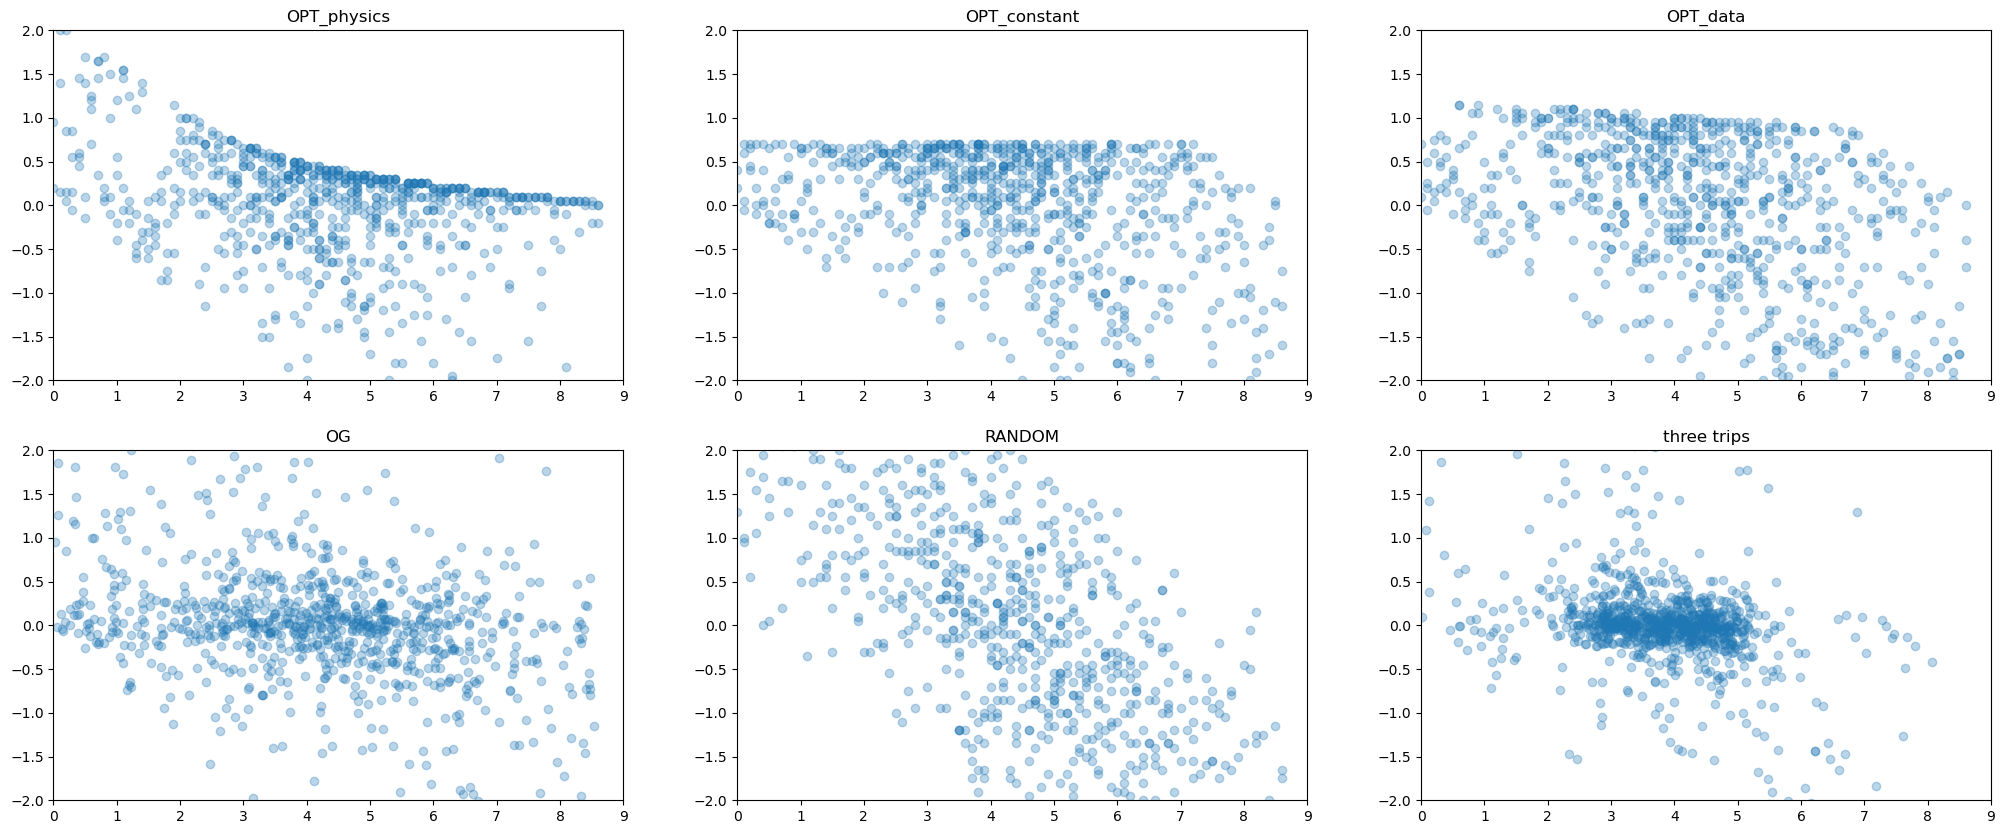

In [1536]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel'], 
           y=frame['acc'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel"],
                y=sub_frame["acc"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])

plt.show()

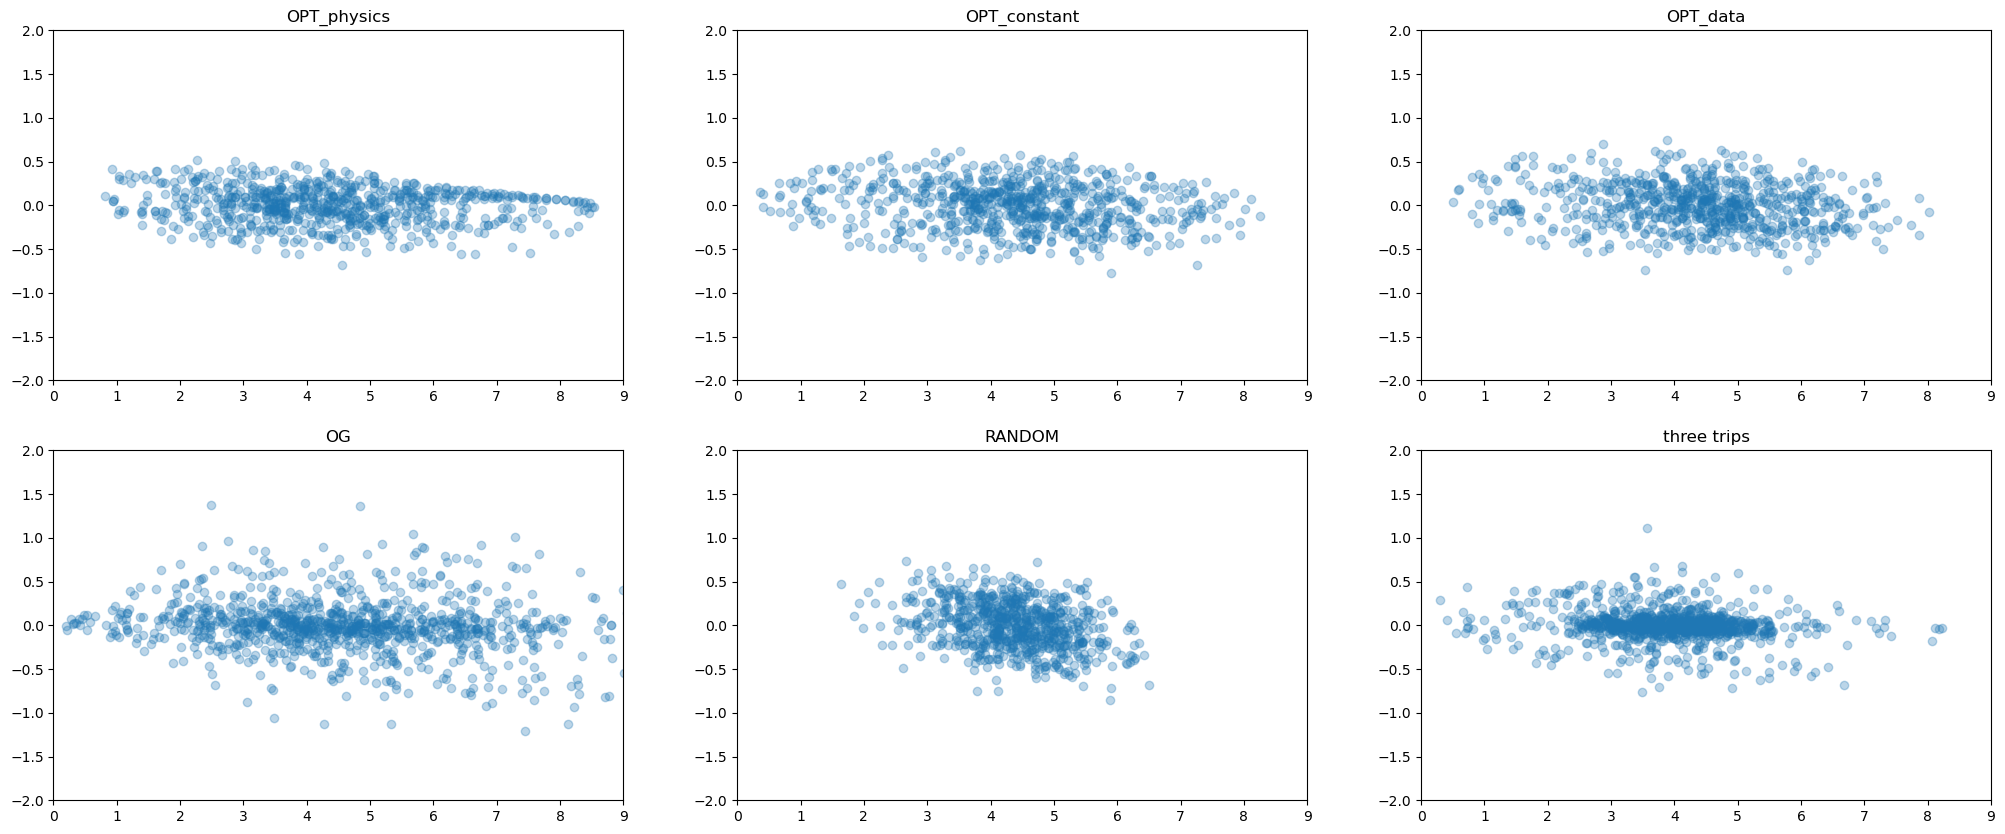

In [1535]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel_smooth'], 
           y=frame['acc_smooth'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel_smooth"],
                y=sub_frame["acc_smooth"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])


plt.show()

# SMOOTH (not now)

In [1326]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]




In [1546]:
compare_H = H_scaled + [0 for x in range(len(comb_H)-len(H_scaled))]
comb_H = comb_H
opt_H = opt_df_list[2].groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
rand_H = rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
comb_abs = 0
opt_abs = 0
rand_abs = 0
for i in range(len(comb_H)):
    x = compare_H[i]
    comb_abs += abs(x-comb_H[i])
    opt_abs += abs(x-opt_H[i])
    rand_abs += abs(x-rand_H[i])
print(comb_abs)
print(opt_abs)
print(rand_abs)

In [1549]:
print("mean velocity:")
print("OG data:", round(GM.loc[GM["vel_smooth"]<=8.6]["vel_smooth"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel_smooth"].mean(),2))
print("random:", round(rand_df["vel_smooth"].mean(),2))
print("three trips:", round((trips_df_list[0]["vel_smooth"].mean() + trips_df_list[1]["vel_smooth"].mean() + trips_df_list[2]["vel_smooth"].mean())/3,2))


mean velocity:
OG data: 4.64
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.36
three trips: 3.86


In [1552]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc_smooth"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc_smooth"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc_smooth"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc_smooth"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)

In [1553]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 31.41 %
OPT_constant 36.38 %
OPT_data 33.42 %
OG 27.6 %
RANDOM 34.98 %
three trips 18.48 %

time spent decelerating:
OPT_physics 29.26 %
OPT_constant 35.03 %
OPT_data 34.36 %
OG 28.27 %
RANDOM 36.18 %
three trips 18.21 %

time spent cruising:
OPT_physics 39.33 %
OPT_constant 28.59 %
OPT_data 32.21 %
OG 44.12 %
RANDOM 28.84 %
three trips 63.31 %


In [ ]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="OG", width=0.1, alpha = 0.5)
plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

In [ ]:
plt.bar([x for x in vel], H_scaled,alpha=1,label="OG data", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H,alpha=0.5,label="all three smooth", width=0.1)
plt.bar(vel, opt_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="opt",alpha=0.5,width=0.1)

plt.legend()
plt.show()

# print histogram for optimization

In [500]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [508]:
print(GM.loc[GM["count"] >= 0].groupby("vel_bin").agg("count")["vel_smooth"].tolist())

[2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82,

OG data

In [977]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_OG_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [978]:
print(GM.loc[GM["count"] >= 0].groupby("vel_OG_bin").agg("count")["vel"].tolist())

[23329, 22093, 21072, 20940, 19523, 19394, 19791, 21089, 22748, 22861, 24193, 24749, 23178, 24079, 24440, 24829, 25550, 27295, 27829, 29833, 31934, 33390, 35396, 38128, 39516, 43064, 45229, 49210, 51761, 54598, 57755, 61338, 62515, 66368, 69064, 71186, 72808, 75498, 78976, 80360, 81946, 82269, 82575, 82783, 83064, 81572, 81745, 80742, 80432, 77783, 76819, 75574, 71642, 70879, 68921, 66059, 63581, 60915, 59186, 55475, 53040, 51057, 48173, 45726, 44203, 41409, 39204, 37711, 35251, 33445, 31683, 30057, 28651, 27043, 25469, 24272, 23415, 22098, 21934, 20283, 19213, 18981, 18147, 17528, 16494, 16413, 15416, 14443, 14583, 13872, 13642, 12876, 12715, 12046, 11315, 11560, 11098, 10765, 10631, 10317, 9907, 9715, 9631, 9218, 8668, 8573, 8587, 8261, 8003, 7927, 7415, 7206, 6962, 6597, 6219, 6345, 5881, 5935, 5300, 5307, 5242, 4754, 4645, 4357, 4117, 3980, 3849, 3643, 3423, 3259, 2992, 2903, 2714, 2544, 2449, 2336, 2161, 2007, 1851, 1846, 1714, 1636, 1517, 1418, 1242, 1182, 1122, 1005, 992, 905, 8

# PP plots

In [ ]:
color1=mcp.gen_color(cmap="viridis",n=4)

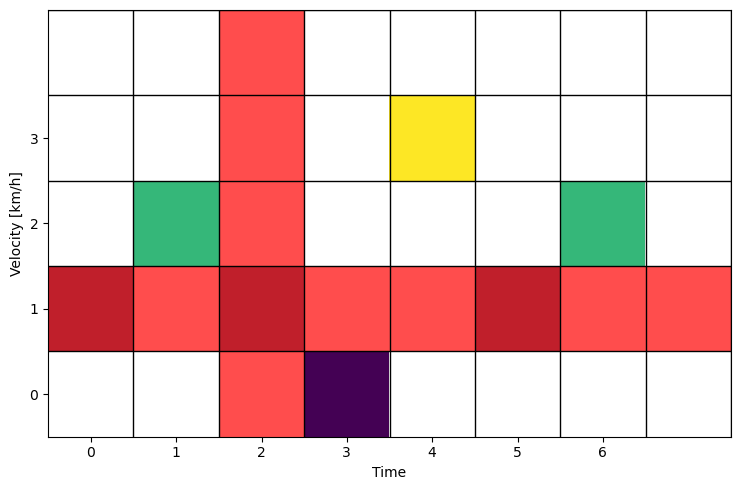

In [975]:
N = 8 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data
data2 = np.ones((M,N))*np.nan

def trip_1(order_list):
    data[0][order_list[0]] = 0 #[y][x]
    data[1][order_list[1]] = 1 #[y][x]
    data[1][order_list[2]] = 1 #[y][x]
    data[1][order_list[3]] = 1 #[y][x]
    data[2][order_list[4]] = 2 #[y][x]
    data[2][order_list[5]] = 2 #[y][x]
    data[3][order_list[6]] = 3 #[y][x]
    sss = 3

    
def const1():
    for i in range(5):
        data2[i][2] = 4
    for i in range(8):
        data2[1][i] = 4
#order_list = [0,1,2,3,4,5,6]
#random.shuffle(order_list)

trip_1(order_list)

a = const1()



# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[0:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)


my_cmap2 = colors.ListedColormap(mcp.gen_color(cmap="hsv",n=1))
# set the 'bad' values (nan) to be white and transparent
my_cmap2.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
plt.xlabel("Time")
plt.ylabel("Velocity [km/h]")

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower');
ax.imshow(data2, interpolation='none', cmap=my_cmap2, zorder=0, origin='lower', alpha = 0.7);
# turn off the axis labels
#ax.axis('off')

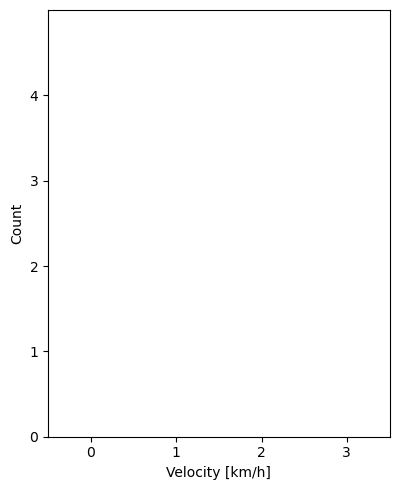

In [817]:
N = 4 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data


# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[3:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
#for x in range(N + 1):
#    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
#    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N, dtype=np.int64))
plt.yticks(np.arange(0, M, dtype=np.int64))


def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-0.5, y), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


#data[0][0]=0
#highlight_cell(0,0, color="black", linewidth=1)

#data[0][1]=1
#highlight_cell(1,0, color="black", linewidth=1)

#data[1][1]=1
#highlight_cell(1,1, color="black", linewidth=1)

#data[2][1]=1
#highlight_cell(1,2, color="black", linewidth=1)

#data[0][2]=2
#highlight_cell(2,0, color="black", linewidth=1)

#data[1][2]=2
#highlight_cell(2,1, color="black", linewidth=1)

#data[0][3]=3
#highlight_cell(3,0, color="black", linewidth=1)

ax.imshow(data, interpolation='none', cmap=my_cmap,extent=[-0.5,N-0.5,0,M], zorder=0, origin='lower')
plt.xlabel("Velocity [km/h]")
plt.ylabel("Count")

plt.show()
# turn off the axis labels
#ax.axis('off')

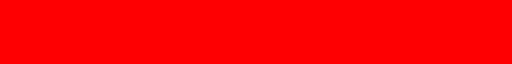

In [676]:
order_list = [0,1,2,3,4,5,6]



None


In [700]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "plt_vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

H_tilf = GM.loc[GM["count"] >= 0].groupby("plt_vel_bin").agg("count")["vel_smooth"].tolist()

In [726]:
#H_tilf = [2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82, 62, 52, 57, 36, 50, 37, 29, 27, 33, 28, 22, 28, 19, 24, 28, 14, 24, 20, 16, 22, 16, 16, 20, 14, 34, 24, 22, 19, 23, 38, 33, 30, 40, 45, 59, 73, 68, 74, 55, 140, 131, 85, 3]
H_scaled = [round(x/sum(H_tilf)*25) for x in H_tilf][0:10]



In [727]:
print(H_scaled)

[1, 1, 2, 4, 5, 4, 3, 2, 1, 1]


In [711]:
from mycolorpy import colorlist as mcp

In [728]:
color1=mcp.gen_color(cmap="viridis",n=len(H_scaled))
print(color1)

['#440154', '#482878', '#3e4989', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6ece58', '#b5de2b', '#fde725']


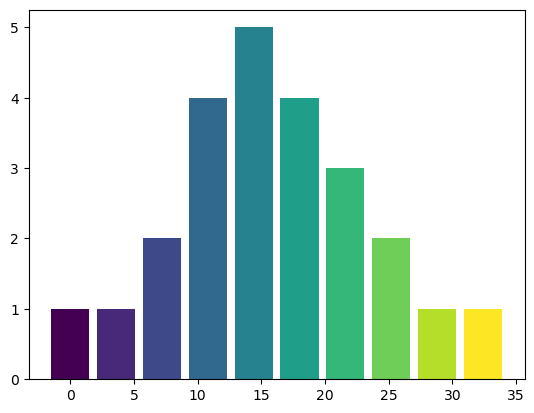

In [729]:
vel_km = [round(x/1*60*60/1000,2) for x in range(len(H_scaled))]
plt.bar(vel_km,H_scaled, color=color1, width=3)
plt.show()

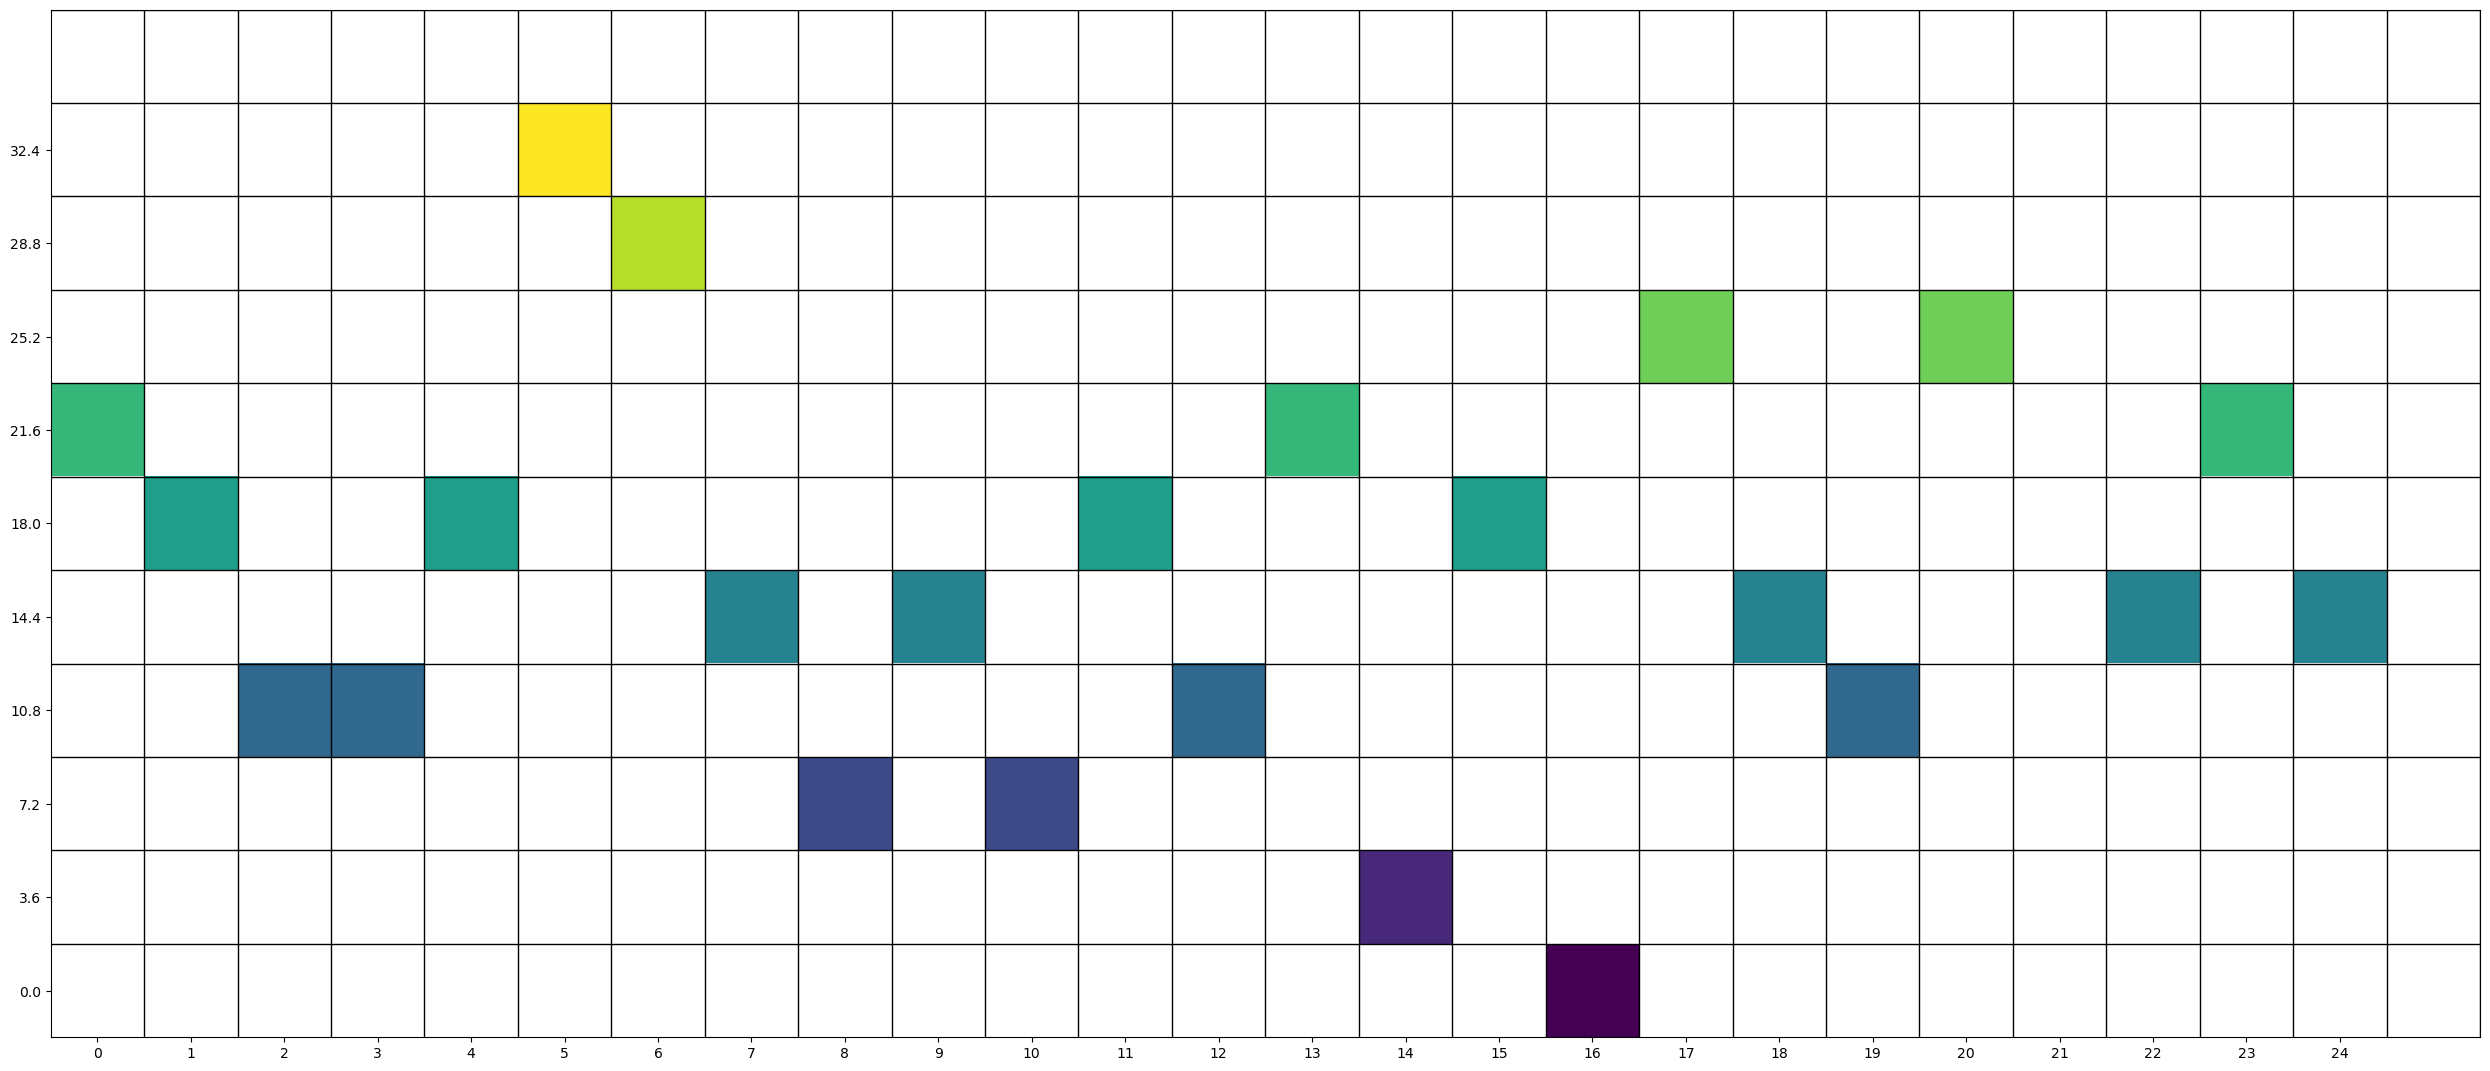

In [750]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data



def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1


order_list = [x for x in range(25)]
random.shuffle(order_list)

trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower');
# turn off the axis labels
#ax.axis('off')

In [ ]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data



def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1


order_list = [x for x in range(25)]
random.shuffle(order_list)

trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower')
plt.show()
# turn off the axis labels
#ax.axis('off')

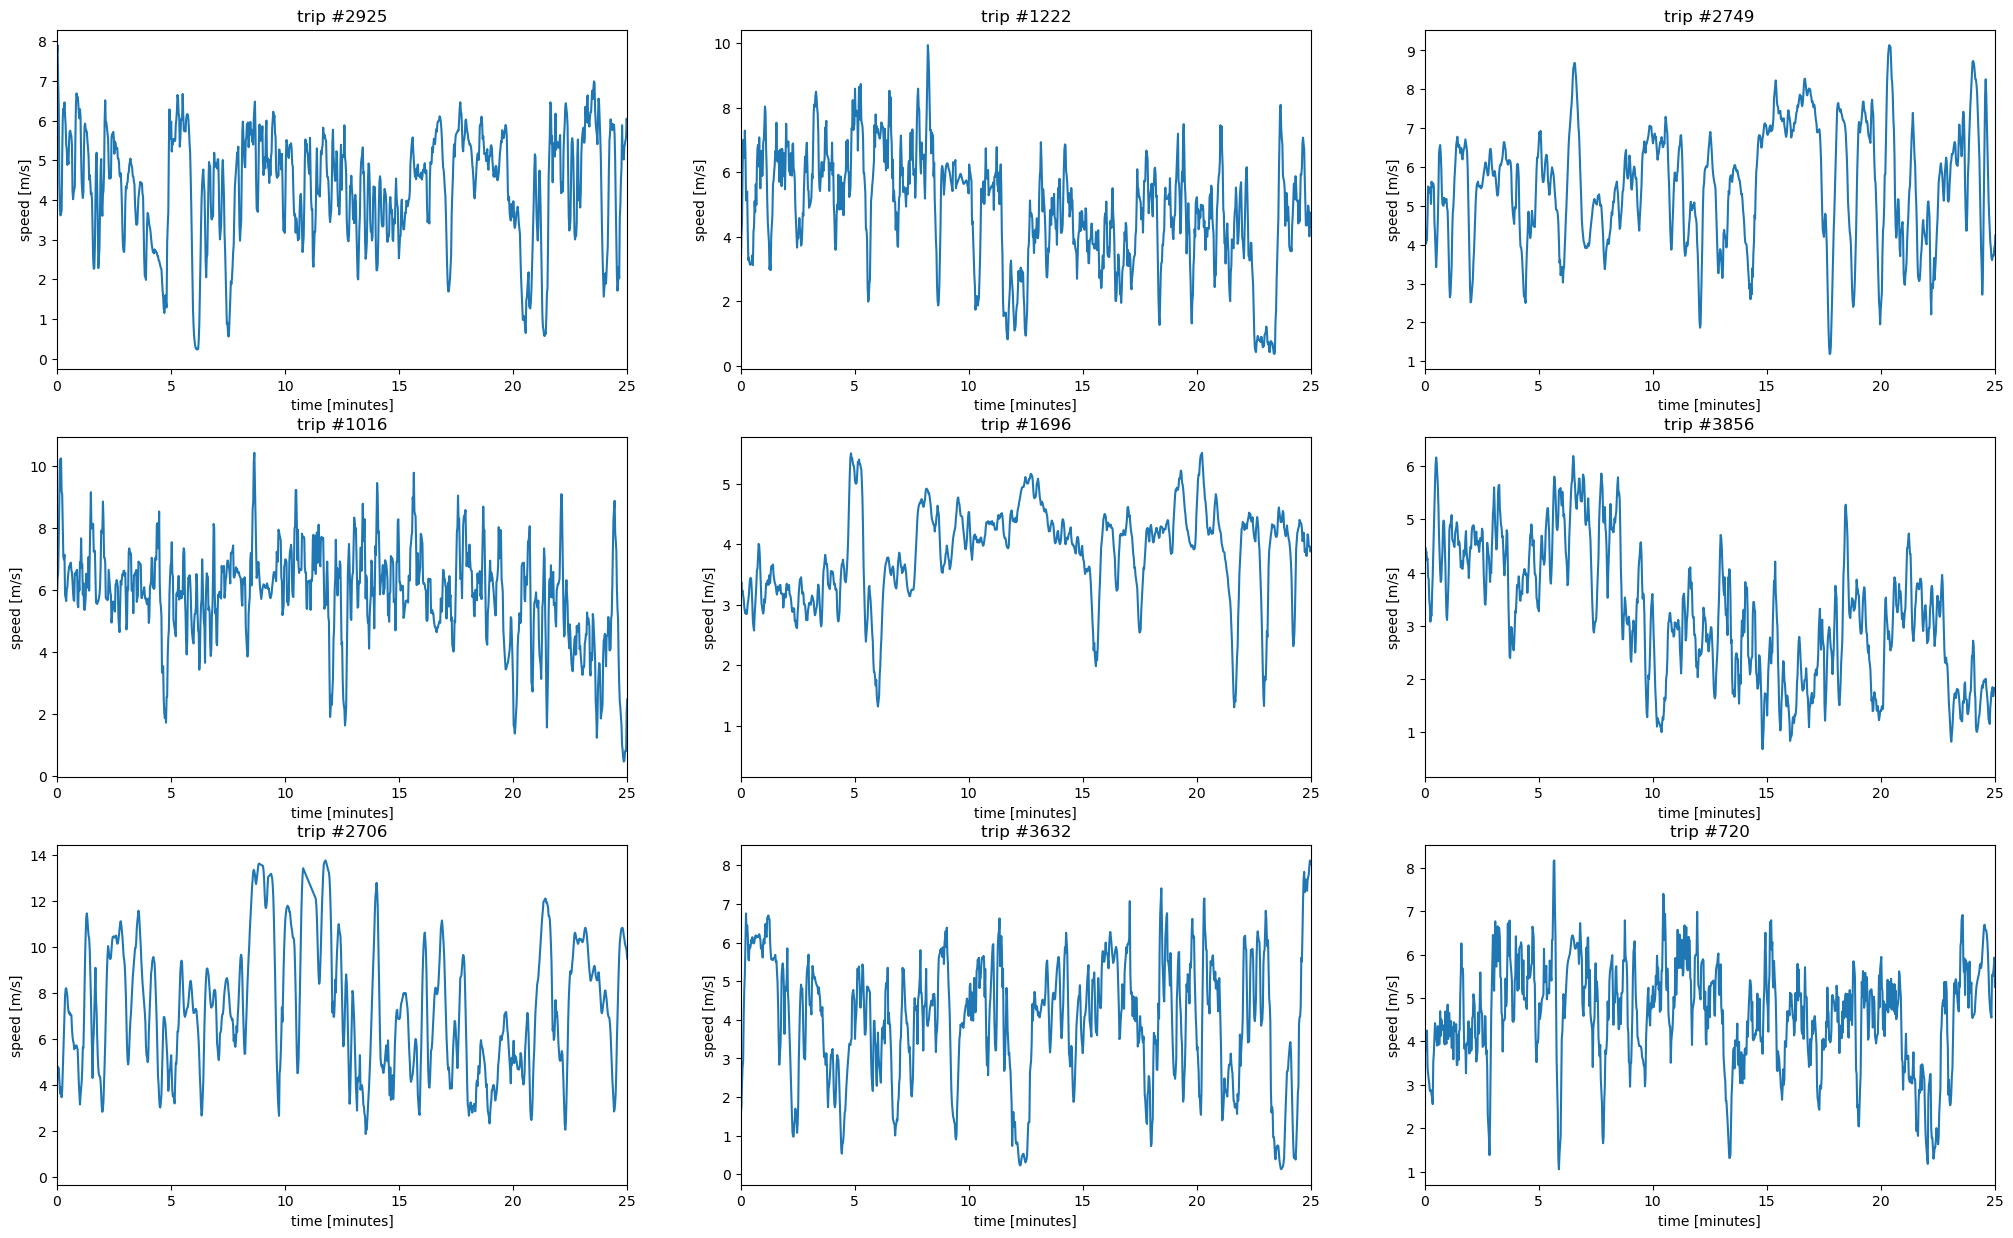

In [1042]:
N = 9

trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[trips[i]]
    times = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 25])
    plt.title("trip #"+str(trip))

plt.show()

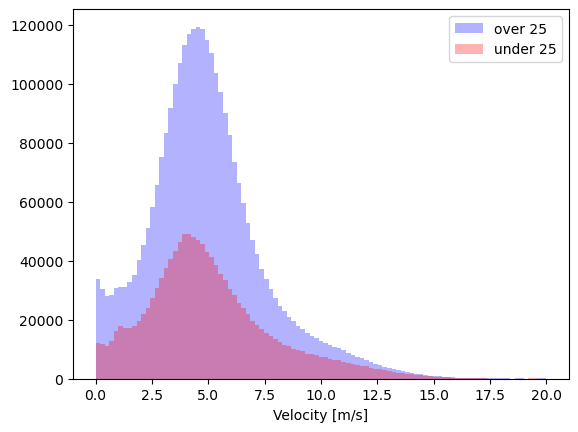

In [1183]:
bins = np.linspace(0, 20, 100) 
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]>=25)]["vel"], label='over 25', bins=bins, alpha=0.3, color='blue')
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]<=25)]["vel"], label='under 25', bins=bins, alpha=0.3, color='red')

plt.xlabel("Velocity [m/s]")
plt.legend()
 
plt.show()

# discarded: 
cruising band

In [ ]:
V = opt_df["vel_smooth"].tolist()
cale = []
idx_cale = []

for i in range(len(V)):
    v_list = []
    idx_li = []
    v = V[i]
    for j in range(i,len(V)):
        u = V[j]
        if u < v*1.07 and u > v*0.93:
            v_list.append(u)
            idx_li.append(j)
        else:
            if len(v_list) >= 5:
                cale.append(v_list)
                idx_cale.append(idx_li)
                #for el in idx_li:
                #    if el != idx_cale:
                #        idx_cale.append(el)
            break
            
idx_uni = []
col_idx = [0 for x in range(len(opt_df))]


for i in range(len(cale)):
    for el in idx_cale[i]:
        if el not in idx_uni:
            idx_uni.append(el)
            col_idx[el] = 1

In [620]:
print("hallo world")

hallo world


In [623]:
number_list = []
nr_list = []
n_list = [x for x in range(10)]

for number in range(10):
    number_list.append(number)
    nr_list += [number]
    
    
print(number_list)
print(nr_list)
print(n_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
#Here we find the elevationdata in the point closest to the point we have
#this could perhaps be done better if we instead use interpolation
#maybe something to look into
#we also save "dist" which denotes the distance between the gps-point and the elevation data used
#i.e. dist is a measurment of how sure we can be of the assigned elevation

def ckdnearest(gdA, gdB):
    
    nA = np.array(list(gdA.geometry.apply(lambda x: (Point(x.coords[0]).x, Point(x.coords[0]).y))))
    nB = gdB[["lat","long"]]
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)

    gdB_nearest = gdB.iloc[idx]["elevation"]#.drop(columns="geometry").reset_index(drop=True)
    el_li = gdB.iloc[idx]["elevation"].tolist()
    return el_li, dist

elevation_list, dist_list = ckdnearest(gdf, df_el)
gdf["elevation"] = elevation_list
gdf["dist"] = dist_list

In [513]:
#df = pd.read_json(r"reseaucyclable201511.json")

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

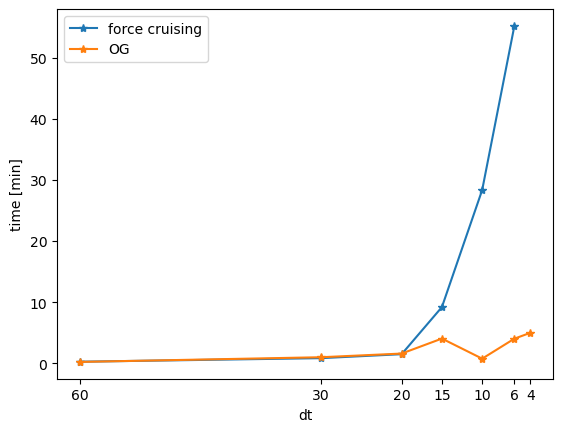

In [806]:
#500 sek dt 10
#1699 for 8 dt
#dt 6 3310
#old dt4 300
#old dt2 3000

x = [6,10,15,20,30,60]
y = [3310,1700,552,90,51,16]
y=[i/60 for i in y]
plt.plot(x,y, "*-",label="force cruising")
x = [4,6,10,15,20,30,60]
y = [300,242,46,243,96,60,14]
y=[i/60 for i in y]
plt.plot(x,y,"*-",label="OG")
plt.gca().invert_xaxis()
plt.xlabel("dt")
plt.ylabel("time [min]")
plt.xticks(x)
plt.legend()
plt.show()

In [807]:
a = [1,2,3]
a[-1]

3

In [ ]:
frame = gm.sample(10000)

plt.scatter(frame["vel"], frame["acc"], alpha=0.01)
plt.ylim([-2,2])
plt.xlim([0,10])
plt.show()